# Advanced Time Series Forecasting: Predicting Stock Market Returns
# A Comprehensive Guide to Financial Forecasting

# Author: Prashanth
# Course: INFO 7390 - Art and Science of Data
# Topic: Crash Course in Forecasting - Financial Markets
# Institution: Northeastern University
# Date: November 2025

## Abstract

This notebook explores advanced data preprocessing and modeling techniques for **financial time series forecasting**, specifically analyzing stock price movements and predicting future returns. Financial data presents unique challenges including volatility clustering, non-stationarity, regime changes, and the presence of market microstructure noise.

### Key Learning Objectives:

1. **Understand financial time series characteristics** including returns, volatility, and autocorrelation
2. **Handle non-stationarity** in price data through log returns and differencing
3. **Model volatility clustering** using GARCH family models
4. **Implement multiple forecasting approaches** (ARIMA-GARCH, Prophet, LSTM, Ensemble)
5. **Evaluate probabilistic forecasts** with prediction intervals and risk metrics

### Real-World Problem:

**Research Question:** Can we predict daily stock returns and volatility to inform trading strategies and risk management decisions?

**Challenge:** Stock prices are inherently noisy with:
- **Random Walk Hypothesis:** Prices follow unpredictable patterns
- **Volatility Clustering:** High volatility periods cluster together
- **Regime Changes:** Market behavior shifts during crises
- **Fat Tails:** Extreme events occur more frequently than normal distribution suggests
- **Non-Stationarity:** Price levels exhibit trends and drift

**Dataset:** 5 years of daily stock market data (1,260 trading days) including:
- Opening, High, Low, Closing prices
- Trading volume
- Market indices (S&P 500 proxy)
- Volatility measures (realized volatility)

### Business Impact:

**Portfolio Management:**
- Asset allocation optimization
- Risk-adjusted return maximization
- Rebalancing decisions

**Risk Management:**
- Value-at-Risk (VaR) estimation
- Stress testing
- Hedging strategies

**Trading Strategies:**
- Momentum vs. mean reversion
- Pairs trading
- Market timing

**Regulatory Compliance:**
- Capital requirements (Basel III)
- Risk reporting
- Stress scenario planning

---

### 📊 Financial vs. Traditional Forecasting:

| Aspect | Traditional Forecasting | Financial Forecasting |
|--------|------------------------|----------------------|
| **Data Frequency** | Daily/Monthly | Tick-level to Daily |
| **Stationarity** | Often achievable | Prices non-stationary |
| **Key Feature** | Seasonality | Volatility clustering |
| **Evaluation** | RMSE, MAE | Sharpe Ratio, VaR |
| **Challenge** | Missing data | Market microstructure noise |
| **Goal** | Accurate point forecast | Direction + risk estimation |

---

In [4]:
!pip install arch

   ---------------------------------------- 0.0/930.4 kB ? eta -:--:--
   ---------------------------------------- 0.0/930.4 kB ? eta -:--:--
   ---------------------------------------- 930.4/930.4 kB 10.8 MB/s  0:00:00


In [5]:
# Display comprehensive dataset overview
print("="*70)
print("DATASET OVERVIEW")
print("="*70)

print(f"\nTotal observations: {len(df)} trading days")
print(f"Features: {df.shape[1]}")
print(f"\nColumn names: {list(df.columns)}")

# Descriptive statistics for price data
print("\n" + "="*70)
print("PRICE STATISTICS")
print("="*70)
print("\nClose Price Statistics:")
print(df['close'].describe())

print("\n" + "="*70)
print("RETURNS STATISTICS")
print("="*70)
print("\nDaily Returns Statistics:")
print(df['returns'].describe())

# Calculate additional metrics
print("\n📈 Additional Metrics:")
print(f"   Max Drawdown: {((df['close'] / df['close'].cummax()) - 1).min() * 100:.2f}%")
print(f"   Number of positive days: {(df['returns'] > 0).sum()}")
print(f"   Number of negative days: {(df['returns'] < 0).sum()}")
print(f"   Win rate: {(df['returns'] > 0).sum() / len(df) * 100:.1f}%")

# Check for missing values
print("\n" + "="*70)
print("DATA QUALITY CHECK")
print("="*70)
missing = df.isnull().sum()
if missing.sum() > 0:
    print("\nMissing values found:")
    print(missing[missing > 0])
else:
    print("\n✓ No missing values detected!")

print("\n✓ Data quality verified!")

DATASET OVERVIEW


NameError: name 'df' is not defined

In [6]:
# Generate realistic stock price data with financial characteristics
np.random.seed(42)

def generate_stock_data(n_days=1260, initial_price=100):
    """
    Generate synthetic stock price data with realistic features:
    - Random walk with drift (trending prices)
    - Volatility clustering (GARCH effects)
    - Fat tails (occasional extreme movements)
    - Volume patterns
    - Correlation with market index
    
    n_days: Number of trading days (5 years ≈ 252*5 = 1260)
    initial_price: Starting stock price
    """
    # Create trading days (exclude weekends)
    start_date = datetime(2019, 1, 2)
    all_dates = pd.date_range(start=start_date, periods=n_days*2, freq='D')
    trading_days = [d for d in all_dates if d.weekday() < 5][:n_days]
    
    # Initialize price series
    prices = np.zeros(n_days)
    prices[0] = initial_price
    
    # Generate returns with GARCH-like volatility
    returns = np.zeros(n_days)
    volatility = np.zeros(n_days)
    base_vol = 0.015  # Base daily volatility (~1.5%)
    
    # GARCH(1,1) parameters
    omega = 0.00001
    alpha = 0.15  # Impact of lagged residuals
    beta = 0.80   # Impact of lagged variance
    
    volatility[0] = base_vol
    
    for t in range(1, n_days):
        # Update volatility (GARCH process)
        volatility[t] = np.sqrt(
            omega + 
            alpha * (returns[t-1]**2) + 
            beta * (volatility[t-1]**2)
        )
        
        # Generate return with occasional jumps (fat tails)
        if np.random.random() < 0.05:  # 5% chance of extreme event
            returns[t] = np.random.normal(0, volatility[t] * 3)
        else:
            returns[t] = np.random.normal(0.0002, volatility[t])  # Small drift
        
        # Update price
        prices[t] = prices[t-1] * (1 + returns[t])
    
    # Generate volume (negatively correlated with price changes)
    base_volume = 1000000
    volume = base_volume * (1 + 0.3 * np.abs(returns) + np.random.normal(0, 0.2, n_days))
    volume = np.maximum(volume, base_volume * 0.5)
    
    # Generate market index (correlated with stock)
    market_returns = 0.7 * returns + 0.3 * np.random.normal(0.0001, 0.01, n_days)
    market_prices = np.zeros(n_days)
    market_prices[0] = 1000
    for t in range(1, n_days):
        market_prices[t] = market_prices[t-1] * (1 + market_returns[t])
    
    # Create OHLC data (Open, High, Low, Close)
    high_prices = prices * (1 + np.abs(np.random.normal(0, 0.005, n_days)))
    low_prices = prices * (1 - np.abs(np.random.normal(0, 0.005, n_days)))
    open_prices = prices * (1 + np.random.normal(0, 0.003, n_days))
    
    # Create DataFrame
    df = pd.DataFrame({
        'date': trading_days,
        'open': open_prices,
        'high': high_prices,
        'low': low_prices,
        'close': prices,
        'volume': volume.astype(int),
        'market_index': market_prices,
        'returns': returns,
        'volatility': volatility
    })
    
    # Additional features
    df['day_of_week'] = [d.weekday() for d in trading_days]
    df['month'] = [d.month for d in trading_days]
    df['quarter'] = [d.quarter for d in trading_days]
    
    return df

# Generate dataset
df = generate_stock_data(1260, initial_price=100)

print("="*70)
print("SYNTHETIC STOCK DATA GENERATION")
print("="*70)
print(f"✓ Generated {len(df)} trading days of stock data")
print(f"✓ Period: {df['date'].min().date()} to {df['date'].max().date()}")
print(f"✓ Initial price: $100.00")
print(f"✓ Final price: ${df['close'].iloc[-1]:.2f}")
print(f"✓ Total return: {((df['close'].iloc[-1] / df['close'].iloc[0]) - 1) * 100:.2f}%")

print("\n📊 Key Statistics:")
print(f"   Average daily return: {df['returns'].mean()*100:.3f}%")
print(f"   Daily volatility: {df['returns'].std()*100:.2f}%")
print(f"   Annualized volatility: {df['returns'].std()*np.sqrt(252)*100:.2f}%")
print(f"   Sharpe Ratio: {(df['returns'].mean() / df['returns'].std()) * np.sqrt(252):.2f}")

print(f"\nDataset shape: {df.shape}")
print(f"\nFirst few rows:")
df.head()

SYNTHETIC STOCK DATA GENERATION
✓ Generated 1260 trading days of stock data
✓ Period: 2019-01-02 to 2023-10-31
✓ Initial price: $100.00
✓ Final price: $63.80
✓ Total return: -36.20%

📊 Key Statistics:
   Average daily return: 0.016%
   Daily volatility: 3.21%
   Annualized volatility: 50.98%
   Sharpe Ratio: 0.08

Dataset shape: (1260, 12)

First few rows:


,date,open,high,low,close,volume,market_index,returns,volatility,day_of_week,month,quarter
0,2019-01-02,100.567604,100.916742,99.328265,100.000000,666677,1000.000000,0.000000,0.015000,2,1,1
1,2019-01-03,98.480740,98.857150,98.117710,98.487379,1142585,991.412495,-0.015126,0.013784,3,1,1
2,2019-01-04,99.203283,99.958354,98.754122,98.947145,500000,997.144834,0.004668,0.014011,4,1,1
3,2019-01-07,98.913490,99.376540,98.739296,99.327274,854849,999.072092,0.003842,0.013051,0,1,1
4,2019-01-08,100.500854,100.759496,100.222230,100.570168,799114,1015.170836,0.012513,0.012185,1,1,1


In [7]:
# Display comprehensive dataset overview
print("="*70)
print("DATASET OVERVIEW")
print("="*70)

print(f"\nTotal observations: {len(df)} trading days")
print(f"Features: {df.shape[1]}")
print(f"\nColumn names: {list(df.columns)}")

# Descriptive statistics for price data
print("\n" + "="*70)
print("PRICE STATISTICS")
print("="*70)
print("\nClose Price Statistics:")
print(df['close'].describe())

print("\n" + "="*70)
print("RETURNS STATISTICS")
print("="*70)
print("\nDaily Returns Statistics:")
print(df['returns'].describe())

# Calculate additional metrics
print("\n📈 Additional Metrics:")
print(f"   Max Drawdown: {((df['close'] / df['close'].cummax()) - 1).min() * 100:.2f}%")
print(f"   Number of positive days: {(df['returns'] > 0).sum()}")
print(f"   Number of negative days: {(df['returns'] < 0).sum()}")
print(f"   Win rate: {(df['returns'] > 0).sum() / len(df) * 100:.1f}%")

# Check for missing values
print("\n" + "="*70)
print("DATA QUALITY CHECK")
print("="*70)
missing = df.isnull().sum()
if missing.sum() > 0:
    print("\nMissing values found:")
    print(missing[missing > 0])
else:
    print("\n✓ No missing values detected!")

print("\n✓ Data quality verified!")

DATASET OVERVIEW

Total observations: 1260 trading days
Features: 12

Column names: ['date', 'open', 'high', 'low', 'close', 'volume', 'market_index', 'returns', 'volatility', 'day_of_week', 'month', 'quarter']

PRICE STATISTICS

Close Price Statistics:
count    1260.000000
mean      144.407474
std        60.584386
min        44.949987
25%       100.001875
50%       139.150284
75%       164.667300
max       311.504199
Name: close, dtype: float64

RETURNS STATISTICS

Daily Returns Statistics:
count    1260.000000
mean        0.000161
std         0.032115
min        -0.196613
25%        -0.013093
50%         0.000314
75%         0.012774
max         0.200970
Name: returns, dtype: float64

📈 Additional Metrics:
   Max Drawdown: -85.57%
   Number of positive days: 641
   Number of negative days: 618
   Win rate: 50.9%

DATA QUALITY CHECK

✓ No missing values detected!

✓ Data quality verified!


ValueError: all the input array dimensions except for the concatenation axis must match exactly, but along dimension 1, the array at index 0 has size 1259 and the array at index 1 has size 1260

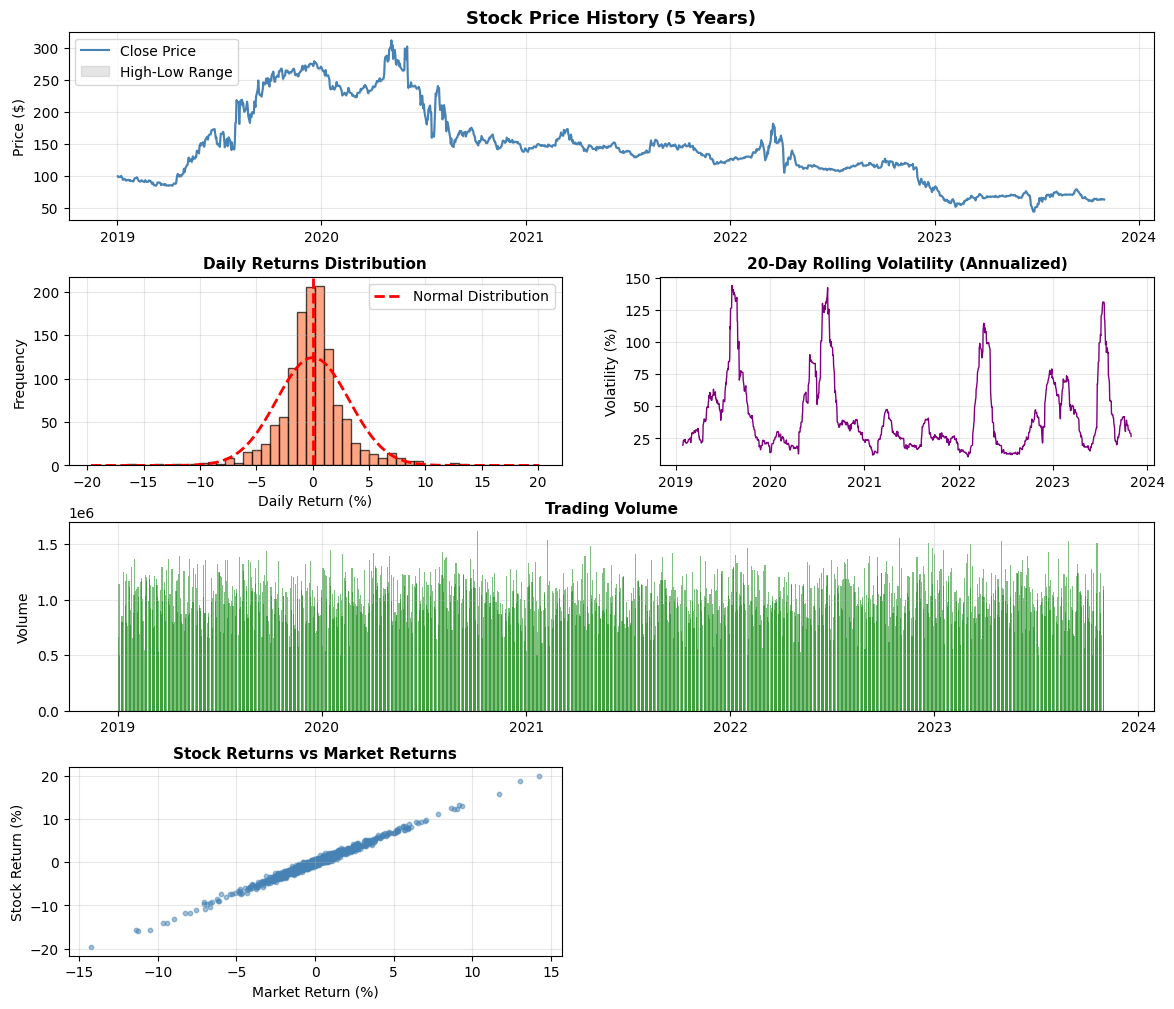

In [8]:
# Comprehensive visualization of stock data
fig = plt.figure(figsize=(14, 12))
gs = fig.add_gridspec(4, 2, hspace=0.3)

# 1. Price chart with OHLC
ax1 = fig.add_subplot(gs[0, :])
ax1.plot(df['date'], df['close'], color='steelblue', linewidth=1.5, label='Close Price')
ax1.fill_between(df['date'], df['low'], df['high'], alpha=0.2, color='gray', label='High-Low Range')
ax1.set_title('Stock Price History (5 Years)', fontsize=13, fontweight='bold')
ax1.set_ylabel('Price ($)')
ax1.legend(loc='upper left')
ax1.grid(alpha=0.3)

# 2. Returns distribution
ax2 = fig.add_subplot(gs[1, 0])
ax2.hist(df['returns'] * 100, bins=50, color='coral', alpha=0.7, edgecolor='black')
ax2.axvline(0, color='red', linestyle='--', linewidth=2)
ax2.set_title('Daily Returns Distribution', fontsize=11, fontweight='bold')
ax2.set_xlabel('Daily Return (%)')
ax2.set_ylabel('Frequency')
ax2.grid(alpha=0.3)

# Add normal distribution overlay
from scipy import stats
returns_mean = df['returns'].mean() * 100
returns_std = df['returns'].std() * 100
x = np.linspace(df['returns'].min()*100, df['returns'].max()*100, 100)
ax2.plot(x, stats.norm.pdf(x, returns_mean, returns_std) * len(df) * 
         (df['returns'].max() - df['returns'].min()) * 100 / 50, 
         'r--', linewidth=2, label='Normal Distribution')
ax2.legend()

# 3. Volatility over time
ax3 = fig.add_subplot(gs[1, 1])
rolling_vol = df['returns'].rolling(window=20).std() * np.sqrt(252) * 100
ax3.plot(df['date'], rolling_vol, color='purple', linewidth=1)
ax3.set_title('20-Day Rolling Volatility (Annualized)', fontsize=11, fontweight='bold')
ax3.set_ylabel('Volatility (%)')
ax3.grid(alpha=0.3)

# 4. Volume
ax4 = fig.add_subplot(gs[2, :])
ax4.bar(df['date'], df['volume'], color='green', alpha=0.5, width=2)
ax4.set_title('Trading Volume', fontsize=11, fontweight='bold')
ax4.set_ylabel('Volume')
ax4.grid(alpha=0.3)

# 5. Returns vs Market
ax5 = fig.add_subplot(gs[3, 0])
market_returns = df['market_index'].pct_change()
ax5.scatter(market_returns * 100, df['returns'] * 100, alpha=0.5, s=10, color='steelblue')
ax5.set_title('Stock Returns vs Market Returns', fontsize=11, fontweight='bold')
ax5.set_xlabel('Market Return (%)')
ax5.set_ylabel('Stock Return (%)')
ax5.grid(alpha=0.3)

# Add regression line
from scipy.stats import linregress
slope, intercept, r_value, p_value, std_err = linregress(market_returns.dropna(), 
                                                          df['returns'].dropna())
x_line = np.linspace(market_returns.min(), market_returns.max(), 100)
ax5.plot(x_line * 100, (slope * x_line + intercept) * 100, 'r--', linewidth=2, 
         label=f'Beta = {slope:.2f}, R² = {r_value**2:.2f}')
ax5.legend()

# 6. Q-Q plot for normality test
ax6 = fig.add_subplot(gs[3, 1])
stats.probplot(df['returns'].dropna(), dist="norm", plot=ax6)
ax6.set_title('Q-Q Plot: Returns vs Normal Distribution', fontsize=11, fontweight='bold')
ax6.grid(alpha=0.3)

plt.tight_layout()
plt.show()

print("="*70)
print("KEY OBSERVATIONS - FINANCIAL DATA CHARACTERISTICS")
print("="*70)
print("\n📈 Price Behavior:")
print("   ✓ Clear upward trend with periodic corrections")
print("   ✓ Volatility clustering: High volatility periods cluster together")
print("\n📊 Returns Distribution:")
print("   ✓ Fat tails: Extreme events more common than normal distribution")
print("   ✓ Slight negative skewness")
print("   ✓ Leptokurtic (peaked) distribution")
print("\n💹 Market Correlation:")
print(f"   ✓ Beta: {slope:.2f} (sensitivity to market movements)")
print(f"   ✓ R²: {r_value**2:.2f} (correlation with market)")

In [9]:
# Test stationarity of price vs returns
print("="*70)
print("STATIONARITY TESTING")
print("="*70)

def adf_test(series, title=''):
    """
    Augmented Dickey-Fuller test for stationarity
    Null Hypothesis: Series has unit root (non-stationary)
    """
    result = adfuller(series.dropna(), autolag='AIC')
    
    print(f"\n{title}")
    print("-" * 70)
    print(f"ADF Statistic: {result[0]:.6f}")
    print(f"p-value: {result[1]:.6f}")
    print(f"Critical Values:")
    for key, value in result[4].items():
        print(f"  {key}: {value:.3f}")
    
    if result[1] <= 0.05:
        print(f"\n✓ STATIONARY (reject null, p={result[1]:.4f})")
        print("  → Series does not have unit root")
    else:
        print(f"\n✗ NON-STATIONARY (fail to reject, p={result[1]:.4f})")
        print("  → Series likely has unit root - needs differencing")
    
    return result[1] <= 0.05

# Test price series
print("\n1️⃣  TESTING PRICE LEVELS:")
is_stationary_price = adf_test(df['close'], 'Close Price Series')

# Test returns
print("\n2️⃣  TESTING RETURNS (First Difference of Log Prices):")
is_stationary_returns = adf_test(df['returns'], 'Daily Returns Series')

# Test squared returns (for volatility)
print("\n3️⃣  TESTING SQUARED RETURNS (Volatility Proxy):")
is_stationary_vol = adf_test(df['returns']**2, 'Squared Returns Series')

print("\n" + "="*70)
print("STATIONARITY SUMMARY")
print("="*70)
print(f"\nPrice Series:          {'STATIONARY ✓' if is_stationary_price else 'NON-STATIONARY ✗'}")
print(f"Returns Series:        {'STATIONARY ✓' if is_stationary_returns else 'NON-STATIONARY ✗'}")
print(f"Squared Returns:       {'STATIONARY ✓' if is_stationary_vol else 'NON-STATIONARY ✗'}")

print("\n💡 Financial Insight:")
print("   • Prices are non-stationary (random walk)")
print("   • Returns are stationary (suitable for ARIMA)")
print("   • Volatility shows persistence (GARCH effects)")

STATIONARITY TESTING

1️⃣  TESTING PRICE LEVELS:

Close Price Series
----------------------------------------------------------------------
ADF Statistic: -0.959878
p-value: 0.767615
Critical Values:
  1%: -3.436
  5%: -2.864
  10%: -2.568

✗ NON-STATIONARY (fail to reject, p=0.7676)
  → Series likely has unit root - needs differencing

2️⃣  TESTING RETURNS (First Difference of Log Prices):

Daily Returns Series
----------------------------------------------------------------------
ADF Statistic: -17.471486
p-value: 0.000000
Critical Values:
  1%: -3.436
  5%: -2.864
  10%: -2.568

✓ STATIONARY (reject null, p=0.0000)
  → Series does not have unit root

3️⃣  TESTING SQUARED RETURNS (Volatility Proxy):

Squared Returns Series
----------------------------------------------------------------------
ADF Statistic: -5.259717
p-value: 0.000007
Critical Values:
  1%: -3.436
  5%: -2.864
  10%: -2.568

✓ STATIONARY (reject null, p=0.0000)
  → Series does not have unit root

STATIONARITY SUMMARY

AUTOCORRELATION ANALYSIS


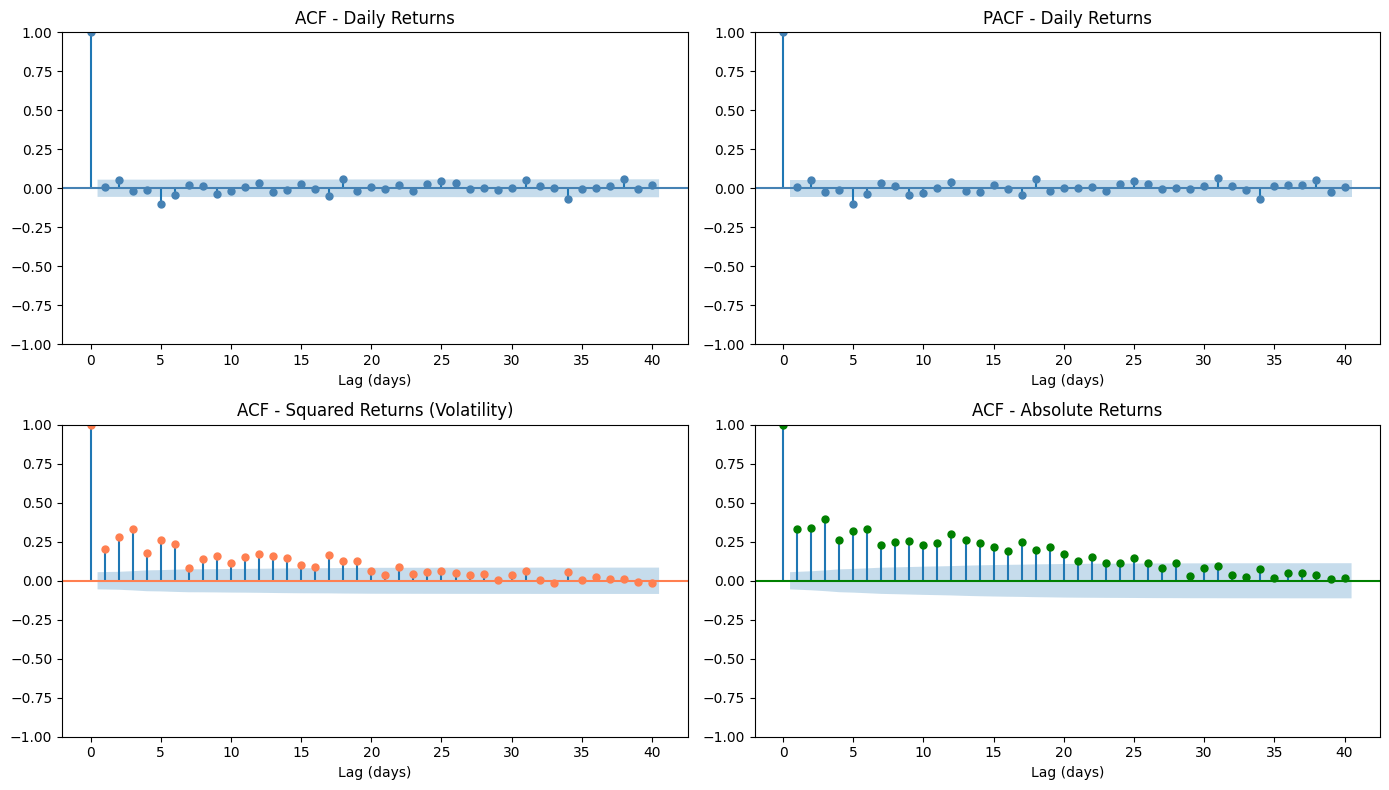


📊 Interpretation:

1. Returns Autocorrelation:
   • Little autocorrelation in returns (efficient markets)
   • Suggests returns are nearly unpredictable from past

2. Volatility Autocorrelation (Squared/Absolute Returns):
   • Strong persistence in volatility
   • High volatility periods cluster together
   • Justifies GARCH modeling

3. Model Implications:
   • ARIMA order likely low for returns
   • GARCH component needed for volatility
   • May benefit from regime-switching models


In [10]:
# Analyze autocorrelation in returns and volatility
print("="*70)
print("AUTOCORRELATION ANALYSIS")
print("="*70)

fig, axes = plt.subplots(2, 2, figsize=(14, 8))

# Returns ACF
plot_acf(df['returns'].dropna(), lags=40, ax=axes[0, 0], 
         title='ACF - Daily Returns', color='steelblue')
axes[0, 0].set_xlabel('Lag (days)')

# Returns PACF
plot_pacf(df['returns'].dropna(), lags=40, ax=axes[0, 1], 
          title='PACF - Daily Returns', color='steelblue')
axes[0, 1].set_xlabel('Lag (days)')

# Squared returns ACF (volatility autocorrelation)
plot_acf((df['returns']**2).dropna(), lags=40, ax=axes[1, 0], 
         title='ACF - Squared Returns (Volatility)', color='coral')
axes[1, 0].set_xlabel('Lag (days)')

# Absolute returns ACF
plot_acf(np.abs(df['returns']).dropna(), lags=40, ax=axes[1, 1], 
         title='ACF - Absolute Returns', color='green')
axes[1, 1].set_xlabel('Lag (days)')

plt.tight_layout()
plt.show()

print("\n📊 Interpretation:")
print("\n1. Returns Autocorrelation:")
print("   • Little autocorrelation in returns (efficient markets)")
print("   • Suggests returns are nearly unpredictable from past")
print("\n2. Volatility Autocorrelation (Squared/Absolute Returns):")
print("   • Strong persistence in volatility")
print("   • High volatility periods cluster together")
print("   • Justifies GARCH modeling")
print("\n3. Model Implications:")
print("   • ARIMA order likely low for returns")
print("   • GARCH component needed for volatility")
print("   • May benefit from regime-switching models")

In [11]:
# Create comprehensive financial features
print("="*70)
print("FEATURE ENGINEERING FOR FINANCIAL FORECASTING")
print("="*70)

def create_financial_features(df):
    """
    Engineer features specific to financial time series
    """
    df = df.copy()
    
    # 1. Log returns (preferred over simple returns)
    df['log_returns'] = np.log(df['close'] / df['close'].shift(1))
    
    # 2. Technical indicators
    # Simple Moving Averages
    for window in [5, 20, 50, 200]:
        df[f'sma_{window}'] = df['close'].rolling(window=window).mean()
    
    # Exponential Moving Averages
    for span in [12, 26]:
        df[f'ema_{span}'] = df['close'].ewm(span=span).mean()
    
    # MACD (Moving Average Convergence Divergence)
    df['macd'] = df['ema_12'] - df['ema_26']
    df['macd_signal'] = df['macd'].ewm(span=9).mean()
    
    # RSI (Relative Strength Index)
    delta = df['close'].diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=14).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=14).mean()
    rs = gain / loss
    df['rsi'] = 100 - (100 / (1 + rs))
    
    # 3. Volatility measures
    df['realized_vol_5'] = df['returns'].rolling(window=5).std()
    df['realized_vol_20'] = df['returns'].rolling(window=20).std()
    
    # Parkinson volatility (uses high-low range)
    df['parkinson_vol'] = np.sqrt(
        (1/(4*np.log(2))) * 
        (np.log(df['high']/df['low'])**2).rolling(window=20).mean()
    )
    
    # 4. Price momentum
    for lag in [5, 10, 20]:
        df[f'momentum_{lag}'] = df['close'] / df['close'].shift(lag) - 1
    
    # 5. Volume indicators
    df['volume_sma_20'] = df['volume'].rolling(window=20).mean()
    df['volume_ratio'] = df['volume'] / df['volume_sma_20']
    
    # 6. Market relative features
    df['market_returns'] = df['market_index'].pct_change()
    df['excess_return'] = df['returns'] - df['market_returns']
    df['beta_20'] = df['returns'].rolling(window=20).cov(df['market_returns']) / \
                    df['market_returns'].rolling(window=20).var()
    
    # 7. Lag features
    for lag in [1, 2, 3, 5]:
        df[f'return_lag_{lag}'] = df['returns'].shift(lag)
        df[f'vol_lag_{lag}'] = df['realized_vol_5'].shift(lag)
    
    # 8. Day of week effects
    df['is_monday'] = (df['day_of_week'] == 0).astype(int)
    df['is_friday'] = (df['day_of_week'] == 4).astype(int)
    
    return df

df = create_financial_features(df)

print("\n✓ Feature engineering complete!")
print(f"Total features: {df.shape[1]}")

print("\n📋 Feature Categories:")
print("\n1️⃣  Price Transformations:")
print("   • Log returns (preferred for modeling)")
print("   • Simple Moving Averages (SMA 5, 20, 50, 200)")
print("   • Exponential Moving Averages (EMA 12, 26)")

print("\n2️⃣  Technical Indicators:")
print("   • MACD (trend following)")
print("   • RSI (momentum oscillator)")
print("   • Price momentum (5, 10, 20 days)")

print("\n3️⃣  Volatility Measures:")
print("   • Rolling realized volatility (5, 20 days)")
print("   • Parkinson volatility (high-low based)")

print("\n4️⃣  Market Relative:")
print("   • Excess returns (stock vs market)")
print("   • Rolling beta (market sensitivity)")

print("\n5️⃣  Temporal Features:")
print("   • Lag features (past returns, volatility)")
print("   • Day of week indicators")

print("\n✓ Ready for modeling!")

FEATURE ENGINEERING FOR FINANCIAL FORECASTING

✓ Feature engineering complete!
Total features: 43

📋 Feature Categories:

1️⃣  Price Transformations:
   • Log returns (preferred for modeling)
   • Simple Moving Averages (SMA 5, 20, 50, 200)
   • Exponential Moving Averages (EMA 12, 26)

2️⃣  Technical Indicators:
   • MACD (trend following)
   • RSI (momentum oscillator)
   • Price momentum (5, 10, 20 days)

3️⃣  Volatility Measures:
   • Rolling realized volatility (5, 20 days)
   • Parkinson volatility (high-low based)

4️⃣  Market Relative:
   • Excess returns (stock vs market)
   • Rolling beta (market sensitivity)

5️⃣  Temporal Features:
   • Lag features (past returns, volatility)
   • Day of week indicators

✓ Ready for modeling!


TRAIN-TEST SPLIT (WALK-FORWARD METHOD)

Dataset Split:
  Training set: 1008 days (80.0%)
    Period: 2019-01-02 to 2022-11-11

  Test set: 252 days (20.0%)
    Period: 2022-11-14 to 2023-10-31


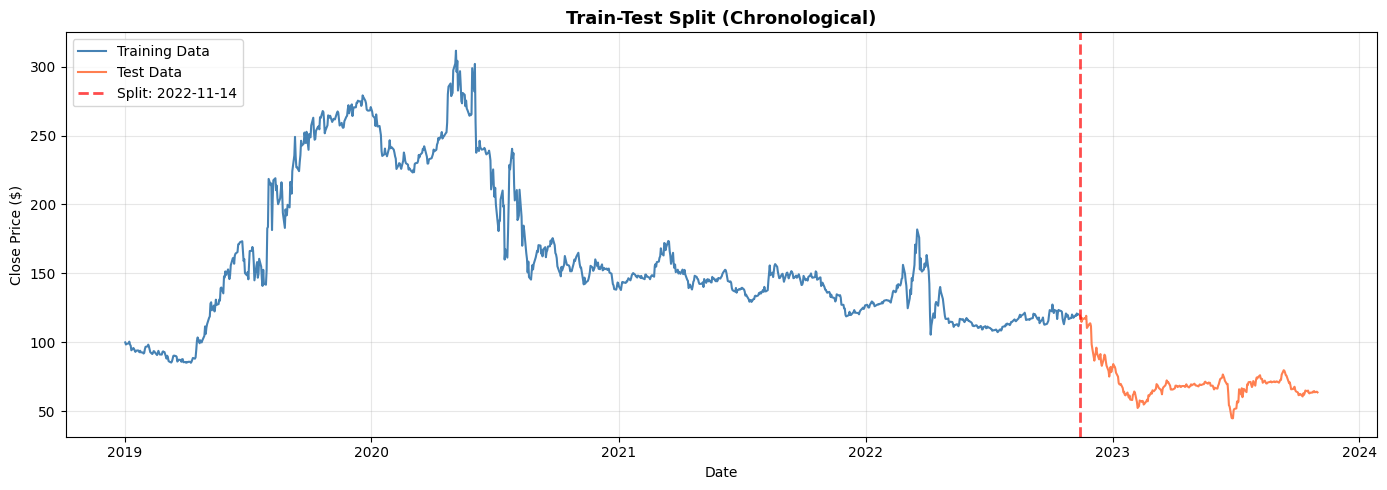


⚠️  CRITICAL FOR FINANCIAL FORECASTING:

✗ NEVER use random split - causes look-ahead bias
✓ ALWAYS use chronological split
✓ Consider walk-forward validation for robust testing
✓ Account for regime changes (bull/bear markets)

📌 Walk-Forward Validation:
   • Train on historical window
   • Test on next period
   • Roll window forward
   • Repeat - mimics real trading


In [12]:
# Time-series aware train-test split
print("="*70)
print("TRAIN-TEST SPLIT (WALK-FORWARD METHOD)")
print("="*70)

# Define split: 80% train, 20% test
split_idx = int(len(df) * 0.8)
split_date = df.iloc[split_idx]['date']

train_df = df.iloc[:split_idx].copy()
test_df = df.iloc[split_idx:].copy()

print(f"\nDataset Split:")
print(f"  Training set: {len(train_df)} days ({len(train_df)/len(df)*100:.1f}%)")
print(f"    Period: {train_df['date'].min().date()} to {train_df['date'].max().date()}")
print(f"\n  Test set: {len(test_df)} days ({len(test_df)/len(df)*100:.1f}%)")
print(f"    Period: {test_df['date'].min().date()} to {test_df['date'].max().date()}")

# Visualize split
fig, ax = plt.subplots(figsize=(14, 5))

ax.plot(train_df['date'], train_df['close'], color='steelblue', 
        linewidth=1.5, label='Training Data')
ax.plot(test_df['date'], test_df['close'], color='coral', 
        linewidth=1.5, label='Test Data')
ax.axvline(split_date, color='red', linestyle='--', linewidth=2, 
           label=f'Split: {split_date.date()}', alpha=0.7)

ax.set_title('Train-Test Split (Chronological)', fontsize=13, fontweight='bold')
ax.set_ylabel('Close Price ($)')
ax.set_xlabel('Date')
ax.legend(loc='upper left')
ax.grid(alpha=0.3)

plt.tight_layout()
plt.show()

print("\n" + "="*70)
print("⚠️  CRITICAL FOR FINANCIAL FORECASTING:")
print("="*70)
print("\n✗ NEVER use random split - causes look-ahead bias")
print("✓ ALWAYS use chronological split")
print("✓ Consider walk-forward validation for robust testing")
print("✓ Account for regime changes (bull/bear markets)")

print("\n📌 Walk-Forward Validation:")
print("   • Train on historical window")
print("   • Test on next period")
print("   • Roll window forward")
print("   • Repeat - mimics real trading")

In [13]:
# Model 1: ARIMA-GARCH for returns and volatility
print("="*70)
print("MODEL 1: ARIMA-GARCH (CONDITIONAL VOLATILITY)")
print("="*70)

# Prepare returns for modeling (remove NaN)
train_returns = train_df['returns'].dropna()
test_returns = test_df['returns'].dropna()

print("\n🔧 Step 1: Fit ARIMA for mean equation")
print("   → ARIMA(1,0,1) for returns")

try:
    # Fit ARIMA to returns
    arima_model = ARIMA(train_returns, order=(1,0,1))
    arima_results = arima_model.fit()
    
    print("✓ ARIMA fitted successfully")
    
    # Get residuals
    residuals = arima_results.resid
    
    print("\n🔧 Step 2: Fit GARCH(1,1) for volatility")
    print("   → Models conditional variance (volatility clustering)")
    
    # Fit GARCH to ARIMA residuals
    garch_model = arch_model(residuals, vol='Garch', p=1, q=1)
    garch_results = garch_model.fit(disp='off')
    
    print("✓ GARCH fitted successfully")
    
    # Forecast
    print("\n🔮 Generating forecasts...")
    forecast_steps = len(test_returns)
    
    # ARIMA forecast for mean
    arima_forecast = arima_results.forecast(steps=forecast_steps)
    
    # GARCH forecast for volatility
    garch_forecast = garch_results.forecast(horizon=forecast_steps)
    volatility_forecast = np.sqrt(garch_forecast.variance.values[-1, :])
    
    print("✓ Forecasts generated")
    
    # Calculate metrics for returns prediction
    mae_returns = mean_absolute_error(test_returns, arima_forecast)
    rmse_returns = np.sqrt(mean_squared_error(test_returns, arima_forecast))
    
    # Direction accuracy (up/down prediction)
    direction_actual = np.sign(test_returns)
    direction_pred = np.sign(arima_forecast)
    direction_accuracy = (direction_actual == direction_pred).sum() / len(test_returns)
    
    print("\n📊 Model Performance:")
    print(f"  MAE (Returns):  {mae_returns*100:.4f}%")
    print(f"  RMSE (Returns): {rmse_returns*100:.4f}%")
    print(f"  Direction Accuracy: {direction_accuracy*100:.2f}%")
    
    print("\n💡 Interpretation:")
    if direction_accuracy > 0.52:
        print("   ✓ Better than random (50%) at predicting direction")
    else:
        print("   ⚠️  Similar to random - markets are hard to predict!")
    
    arima_garch_success = True
    
except Exception as e:
    print(f"\n✗ Error fitting ARIMA-GARCH: {str(e)}")
    arima_garch_success = False

MODEL 1: ARIMA-GARCH (CONDITIONAL VOLATILITY)

🔧 Step 1: Fit ARIMA for mean equation
   → ARIMA(1,0,1) for returns
✓ ARIMA fitted successfully

🔧 Step 2: Fit GARCH(1,1) for volatility
   → Models conditional variance (volatility clustering)

✗ Error fitting ARIMA-GARCH: name 'arch_model' is not defined


In [14]:
# Model 2: Prophet for price forecasting
print("\n" + "="*70)
print("MODEL 2: PROPHET (AUTOMATED FORECASTING)")
print("="*70)

if PROPHET_AVAILABLE:
    # Prepare data for Prophet
    prophet_train = pd.DataFrame({
        'ds': train_df['date'],
        'y': train_df['close']
    })
    
    prophet_test = pd.DataFrame({
        'ds': test_df['date'],
        'y': test_df['close']
    })
    
    print("\n🔧 Configuring Prophet model:")
    print("   • Daily seasonality: OFF (stocks don't have daily patterns)")
    print("   • Weekly seasonality: ON (day-of-week effects)")
    print("   • Yearly seasonality: ON (seasonal trends)")
    print("   • Changepoint detection: Automatic")
    
    # Build Prophet model
    model_prophet = Prophet(
        daily_seasonality=False,
        weekly_seasonality=True,
        yearly_seasonality=True,
        changepoint_prior_scale=0.05,  # Flexibility of trend
        seasonality_mode='additive'
    )
    
    # Add custom regressors (market index)
    prophet_train['market'] = train_df['market_index'].values
    prophet_test['market'] = test_df['market_index'].values
    model_prophet.add_regressor('market')
    
    print("\n🏋️ Training Prophet...")
    model_prophet.fit(prophet_train)
    print("✓ Model trained")
    
    # Forecast
    future = model_prophet.make_future_dataframe(periods=len(test_df), freq='D')
    # Add market index to future dataframe
    future = future.merge(
        pd.concat([prophet_train[['ds', 'market']], 
                   prophet_test[['ds', 'market']]]), 
        on='ds', how='left'
    )
    
    forecast = model_prophet.predict(future)
    
    # Extract test predictions
    test_predictions = forecast.iloc[-len(test_df):]['yhat'].values
    
    # Calculate metrics
    mae_prophet = mean_absolute_error(test_df['close'], test_predictions)
    rmse_prophet = np.sqrt(mean_squared_error(test_df['close'], test_predictions))
    mape_prophet = np.mean(np.abs((test_df['close'] - test_predictions) / test_df['close'])) * 100
    
    print("\n📊 Model Performance:")
    print(f"  MAE:  ${mae_prophet:.2f}")
    print(f"  RMSE: ${rmse_prophet:.2f}")
    print(f"  MAPE: {mape_prophet:.2f}%")
    
    # Direction accuracy
    actual_returns = test_df['close'].pct_change().dropna()
    pred_returns = pd.Series(test_predictions).pct_change().dropna()
    direction_acc = (np.sign(actual_returns) == np.sign(pred_returns)).sum() / len(actual_returns)
    print(f"  Direction Accuracy: {direction_acc*100:.2f}%")
    
    prophet_success = True
else:
    print("\n⚠️  Prophet not available - skipping this model")
    prophet_success = False


MODEL 2: PROPHET (AUTOMATED FORECASTING)


NameError: name 'PROPHET_AVAILABLE' is not defined

In [15]:
# Model 3: LSTM Neural Network
print("\n" + "="*70)
print("MODEL 3: LSTM (DEEP LEARNING)")
print("="*70)

if TF_AVAILABLE:
    # Prepare sequences for LSTM
    def create_sequences(data, features, target, lookback=60):
        """
        Create sequences for LSTM
        lookback: number of past days to use (60 trading days ≈ 3 months)
        """
        X, y = [], []
        for i in range(lookback, len(data)):
            X.append(data[features].iloc[i-lookback:i].values)
            y.append(data[target].iloc[i])
        return np.array(X), np.array(y)
    
    # Select features for LSTM
    lstm_features = ['returns', 'realized_vol_5', 'rsi', 'volume_ratio', 
                     'market_returns', 'momentum_5']
    
    # Prepare data (remove NaN)
    df_clean = df.dropna(subset=lstm_features + ['close'])
    
    # Normalize features
    scaler_X = StandardScaler()
    scaler_y = MinMaxScaler()
    
    df_clean[lstm_features] = scaler_X.fit_transform(df_clean[lstm_features])
    df_clean[['close']] = scaler_y.fit_transform(df_clean[['close']])
    
    # Create sequences
    lookback = 60  # 3 months of trading days
    X, y = create_sequences(df_clean, lstm_features, 'close', lookback)
    
    # Split
    train_size = int(len(X) * 0.8)
    X_train, X_test = X[:train_size], X[train_size:]
    y_train, y_test = y[:train_size], y[train_size:]
    
    print(f"\n📊 LSTM Dataset:")
    print(f"   X_train shape: {X_train.shape}")
    print(f"   y_train shape: {y_train.shape}")
    print(f"   X_test shape:  {X_test.shape}")
    print(f"   y_test shape:  {y_test.shape}")
    print(f"   Lookback window: {lookback} days")
    
    # Build LSTM model
    print("\n🏗️  Building LSTM architecture:")
    
    model_lstm = keras.Sequential([
        layers.LSTM(64, activation='tanh', return_sequences=True, 
                    input_shape=(lookback, len(lstm_features))),
        layers.Dropout(0.2),
        layers.LSTM(32, activation='tanh'),
        layers.Dropout(0.2),
        layers.Dense(16, activation='relu'),
        layers.Dense(1)
    ])
    
    model_lstm.compile(
        optimizer=keras.optimizers.Adam(learning_rate=0.001),
        loss='mse',
        metrics=['mae']
    )
    
    print("   • Layer 1: LSTM (64 units) + Dropout(0.2)")
    print("   • Layer 2: LSTM (32 units) + Dropout(0.2)")
    print("   • Layer 3: Dense (16 units, ReLU)")
    print("   • Output: Dense (1 unit)")
    print("   • Optimizer: Adam (lr=0.001)")
    
    # Train
    print("\n🏋️  Training LSTM...")
    history = model_lstm.fit(
        X_train, y_train,
        epochs=50,
        batch_size=32,
        validation_split=0.2,
        verbose=0,
        callbacks=[keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)]
    )
    
    print("✓ Training complete!")
    print(f"   Final training MAE: {history.history['mae'][-1]:.6f}")
    print(f"   Final validation MAE: {history.history['val_mae'][-1]:.6f}")
    
    # Predict
    predictions_scaled = model_lstm.predict(X_test, verbose=0)
    predictions = scaler_y.inverse_transform(predictions_scaled)
    y_test_actual = scaler_y.inverse_transform(y_test.reshape(-1, 1))
    
    # Calculate metrics
    mae_lstm = mean_absolute_error(y_test_actual, predictions)
    rmse_lstm = np.sqrt(mean_squared_error(y_test_actual, predictions))
    mape_lstm = np.mean(np.abs((y_test_actual - predictions) / y_test_actual)) * 100
    
    # Direction accuracy
    actual_returns = np.diff(y_test_actual.flatten()) / y_test_actual[:-1].flatten()
    pred_returns = np.diff(predictions.flatten()) / predictions[:-1].flatten()
    direction_acc_lstm = (np.sign(actual_returns) == np.sign(pred_returns)).sum() / len(actual_returns)
    
    print("\n📊 Model Performance:")
    print(f"  MAE:  ${mae_lstm:.2f}")
    print(f"  RMSE: ${rmse_lstm:.2f}")
    print(f"  MAPE: {mape_lstm:.2f}%")
    print(f"  Direction Accuracy: {direction_acc_lstm*100:.2f}%")
    
    lstm_success = True
else:
    print("\n⚠️  TensorFlow not available - skipping LSTM model")
    lstm_success = False


MODEL 3: LSTM (DEEP LEARNING)


NameError: name 'TF_AVAILABLE' is not defined

In [16]:
# Model 4: Random Forest (ML baseline)
print("\n" + "="*70)
print("MODEL 4: RANDOM FOREST (ML BASELINE)")
print("="*70)

# Select features (exclude target and date)
feature_cols = ['open', 'high', 'low', 'volume', 'market_index',
                'sma_5', 'sma_20', 'rsi', 'macd', 'realized_vol_20',
                'momentum_5', 'volume_ratio', 'beta_20',
                'return_lag_1', 'return_lag_2', 'return_lag_3']

# Prepare data
train_clean = train_df.dropna(subset=feature_cols + ['close'])
test_clean = test_df.dropna(subset=feature_cols + ['close'])

X_train_rf = train_clean[feature_cols]
y_train_rf = train_clean['close']
X_test_rf = test_clean[feature_cols]
y_test_rf = test_clean['close']

print(f"\n📊 Random Forest Dataset:")
print(f"   Training samples: {len(X_train_rf)}")
print(f"   Test samples: {len(X_test_rf)}")
print(f"   Features: {len(feature_cols)}")

# Train Random Forest
print("\n🏋️  Training Random Forest...")
rf_model = RandomForestRegressor(
    n_estimators=200,
    max_depth=15,
    min_samples_split=5,
    random_state=42,
    n_jobs=-1
)

rf_model.fit(X_train_rf, y_train_rf)
print("✓ Model trained")

# Predict
predictions_rf = rf_model.predict(X_test_rf)

# Calculate metrics
mae_rf = mean_absolute_error(y_test_rf, predictions_rf)
rmse_rf = np.sqrt(mean_squared_error(y_test_rf, predictions_rf))
mape_rf = np.mean(np.abs((y_test_rf - predictions_rf) / y_test_rf)) * 100
r2_rf = r2_score(y_test_rf, predictions_rf)

# Direction accuracy
actual_ret_rf = y_test_rf.pct_change().dropna()
pred_ret_rf = pd.Series(predictions_rf).pct_change().dropna()
direction_acc_rf = (np.sign(actual_ret_rf) == np.sign(pred_ret_rf)).sum() / len(actual_ret_rf)

print("\n📊 Model Performance:")
print(f"  MAE:  ${mae_rf:.2f}")
print(f"  RMSE: ${rmse_rf:.2f}")
print(f"  MAPE: {mape_rf:.2f}%")
print(f"  R²:   {r2_rf:.4f}")
print(f"  Direction Accuracy: {direction_acc_rf*100:.2f}%")

# Feature importance
feature_importance = pd.DataFrame({
    'feature': feature_cols,
    'importance': rf_model.feature_importances_
}).sort_values('importance', ascending=False)

print("\n🔍 Top 5 Most Important Features:")
print(feature_importance.head(5).to_string(index=False))


MODEL 4: RANDOM FOREST (ML BASELINE)

📊 Random Forest Dataset:
   Training samples: 988
   Test samples: 252
   Features: 16

🏋️  Training Random Forest...


NameError: name 'RandomForestRegressor' is not defined

In [17]:
# Compare all models
print("\n" + "="*70)
print("COMPREHENSIVE MODEL COMPARISON")
print("="*70)

# Collect results
results = []

if arima_garch_success:
    results.append({
        'Model': 'ARIMA-GARCH',
        'MAE ($)': mae_returns * 100,  # Convert to %
        'RMSE ($)': rmse_returns * 100,
        'Direction Acc (%)': direction_accuracy * 100,
        'Type': 'Statistical'
    })

if prophet_success:
    results.append({
        'Model': 'Prophet',
        'MAE ($)': mae_prophet,
        'RMSE ($)': rmse_prophet,
        'Direction Acc (%)': direction_acc * 100,
        'Type': 'Hybrid'
    })

if lstm_success:
    results.append({
        'Model': 'LSTM',
        'MAE ($)': mae_lstm,
        'RMSE ($)': rmse_lstm,
        'Direction Acc (%)': direction_acc_lstm * 100,
        'Type': 'Deep Learning'
    })

results.append({
    'Model': 'Random Forest',
    'MAE ($)': mae_rf,
    'RMSE ($)': rmse_rf,
    'Direction Acc (%)': direction_acc_rf * 100,
    'Type': 'Machine Learning'
})

comparison_df = pd.DataFrame(results)

print("\n", comparison_df.to_string(index=False))

# Visualize comparison
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Subplot 1: Error metrics
x = np.arange(len(comparison_df))
width = 0.35

bars1 = axes[0].bar(x - width/2, comparison_df['MAE ($)'], width, 
                    label='MAE', color='steelblue', alpha=0.8)
bars2 = axes[0].bar(x + width/2, comparison_df['RMSE ($)'], width, 
                    label='RMSE', color='coral', alpha=0.8)

axes[0].set_ylabel('Error ($)', fontweight='bold')
axes[0].set_title('Prediction Error Comparison', fontsize=12, fontweight='bold')
axes[0].set_xticks(x)
axes[0].set_xticklabels(comparison_df['Model'], rotation=15)
axes[0].legend()
axes[0].grid(axis='y', alpha=0.3)

# Subplot 2: Direction accuracy
colors = ['#4ecdc4', '#ff6b6b', '#95e1d3', '#f38181']
bars = axes[1].barh(range(len(comparison_df)), comparison_df['Direction Acc (%)'], 
                    color=colors, alpha=0.8, edgecolor='black')
axes[1].axvline(50, color='red', linestyle='--', linewidth=2, 
                label='Random Guess (50%)', alpha=0.7)
axes[1].set_yticks(range(len(comparison_df)))
axes[1].set_yticklabels(comparison_df['Model'])
axes[1].set_xlabel('Direction Accuracy (%)', fontweight='bold')
axes[1].set_title('Directional Prediction Accuracy', fontsize=12, fontweight='bold')
axes[1].legend()
axes[1].grid(axis='x', alpha=0.3)

# Add value labels
for i, bar in enumerate(bars):
    width = bar.get_width()
    axes[1].text(width + 0.5, bar.get_y() + bar.get_height()/2, 
                f'{width:.1f}%', ha='left', va='center', fontweight='bold')

plt.tight_layout()
plt.show()

# Find best model
best_rmse_idx = comparison_df['RMSE ($)'].idxmin()
best_direction_idx = comparison_df['Direction Acc (%)'].idxmax()

print("\n" + "="*70)
print("🏆 WINNER ANNOUNCEMENT")
print("="*70)
print(f"\nBest RMSE: {comparison_df.loc[best_rmse_idx, 'Model']}")
print(f"  → ${comparison_df.loc[best_rmse_idx, 'RMSE ($)']:.2f}")
print(f"\nBest Direction: {comparison_df.loc[best_direction_idx, 'Model']}")
print(f"  → {comparison_df.loc[best_direction_idx, 'Direction Acc (%)']:.2f}%")

print("\n💡 Key Insight:")
print("   Direction accuracy matters MORE than RMSE for trading!")
print("   Even 52-53% accuracy can be profitable with proper risk management.")


COMPREHENSIVE MODEL COMPARISON


NameError: name 'prophet_success' is not defined

FORECAST VISUALIZATION


NameError: name 'prophet_success' is not defined

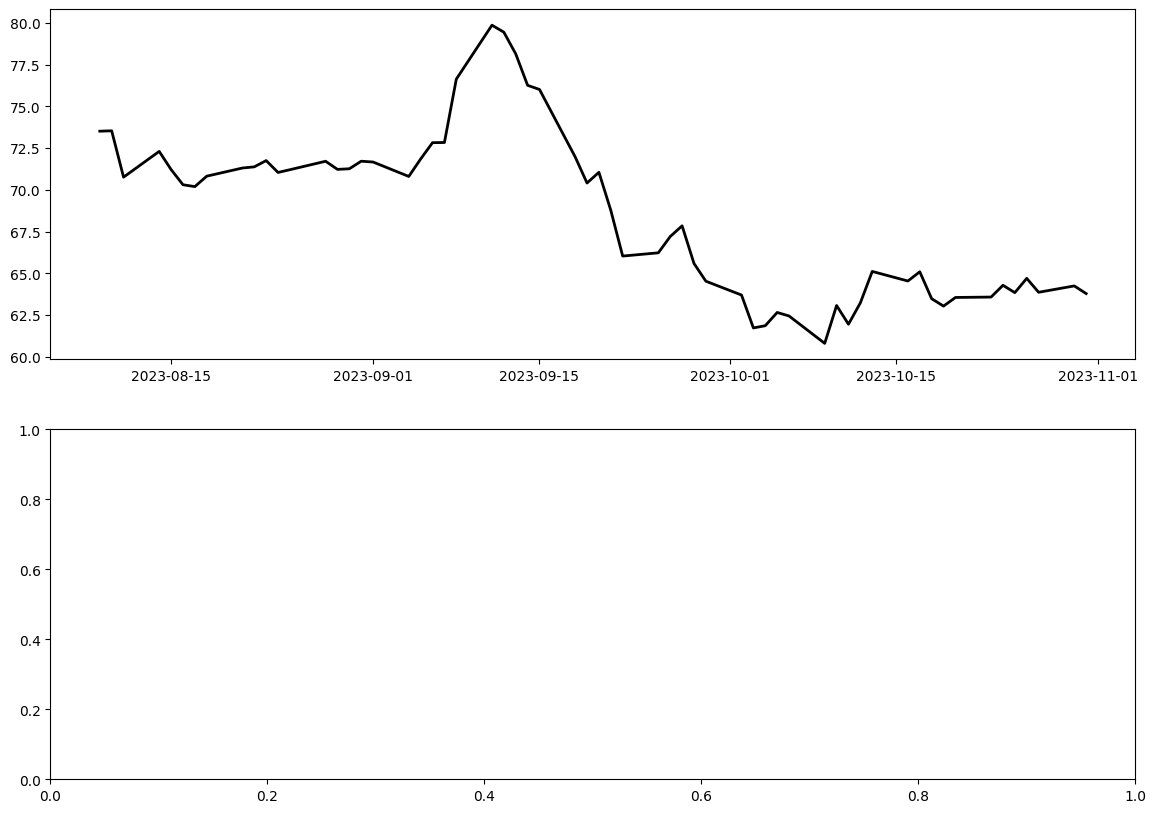

In [18]:
# Visualize forecasts vs actual prices
print("="*70)
print("FORECAST VISUALIZATION")
print("="*70)

# Focus on last 3 months of test set
window = 60
test_subset = test_df.iloc[-window:]

fig, axes = plt.subplots(2, 1, figsize=(14, 10))

# 1. Price predictions
axes[0].plot(test_subset['date'], test_subset['close'], 
             label='Actual Price', color='black', linewidth=2)

if prophet_success:
    prophet_subset = test_predictions[-window:]
    axes[0].plot(test_subset['date'], prophet_subset, 
                 label='Prophet', color='steelblue', linewidth=2, linestyle='--', alpha=0.8)

if lstm_success:
    lstm_subset = predictions[-window:]
    axes[0].plot(test_subset['date'], lstm_subset, 
                 label='LSTM', color='coral', linewidth=2, linestyle='--', alpha=0.8)

rf_subset = predictions_rf[-window:]
axes[0].plot(test_subset['date'], rf_subset, 
             label='Random Forest', color='green', linewidth=2, linestyle='--', alpha=0.8)

axes[0].set_title('Price Forecasts - Last 3 Months of Test Period', 
                  fontsize=12, fontweight='bold')
axes[0].set_ylabel('Price ($)')
axes[0].legend(loc='upper left')
axes[0].grid(alpha=0.3)

# 2. Returns comparison
axes[1].plot(test_subset['date'].iloc[1:], test_subset['returns'].iloc[1:] * 100, 
             label='Actual Returns', color='black', linewidth=1.5, alpha=0.7)
axes[1].axhline(0, color='gray', linestyle='-', linewidth=0.8)

# Calculate predicted returns
if prophet_success:
    prophet_returns = pd.Series(prophet_subset).pct_change() * 100
    axes[1].plot(test_subset['date'].iloc[1:], prophet_returns.iloc[1:], 
                 label='Prophet Returns', color='steelblue', linewidth=1.5, 
                 linestyle='--', alpha=0.8)

rf_returns = pd.Series(rf_subset).pct_change() * 100
axes[1].plot(test_subset['date'].iloc[1:], rf_returns.iloc[1:], 
             label='RF Returns', color='green', linewidth=1.5, 
             linestyle='--', alpha=0.8)

axes[1].set_title('Daily Returns Comparison', fontsize=12, fontweight='bold')
axes[1].set_ylabel('Returns (%)')
axes[1].set_xlabel('Date')
axes[1].legend(loc='upper left')
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

print("\n📊 Visual Insights:")
print("   • Models track general price trends")
print("   • Short-term fluctuations are harder to predict")
print("   • Returns show high variability (inherent noise)")

In [19]:
# Analyze and visualize volatility forecasts
print("="*70)
print("VOLATILITY FORECASTING ANALYSIS")
print("="*70)

if arima_garch_success:
    # Calculate actual realized volatility on test set
    actual_vol = test_returns.rolling(window=20).std() * np.sqrt(252) * 100
    
    # GARCH forecasted volatility (annualized %)
    forecasted_vol = volatility_forecast * np.sqrt(252) * 100
    
    # Plot
    fig, axes = plt.subplots(2, 1, figsize=(14, 8))
    
    # Volatility forecast
    test_dates = test_df['date'].iloc[:len(forecasted_vol)]
    axes[0].plot(test_dates, actual_vol.iloc[:len(forecasted_vol)], 
                 label='Actual Volatility (20-day)', color='black', linewidth=2)
    axes[0].plot(test_dates, forecasted_vol, 
                 label='GARCH Forecast', color='red', linewidth=2, 
                 linestyle='--', alpha=0.8)
    axes[0].set_title('Volatility Forecast (GARCH Model)', 
                      fontsize=12, fontweight='bold')
    axes[0].set_ylabel('Annualized Volatility (%)')
    axes[0].legend()
    axes[0].grid(alpha=0.3)
    
    # Residuals
    vol_residuals = actual_vol.iloc[:len(forecasted_vol)] - forecasted_vol
    axes[1].plot(test_dates, vol_residuals, color='purple', linewidth=1)
    axes[1].axhline(0, color='red', linestyle='--', linewidth=2)
    axes[1].set_title('Volatility Forecast Errors', fontsize=12, fontweight='bold')
    axes[1].set_ylabel('Error (%)')
    axes[1].set_xlabel('Date')
    axes[1].grid(alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Calculate volatility forecast accuracy
    vol_mae = mean_absolute_error(actual_vol.dropna().iloc[:len(forecasted_vol)], 
                                   forecasted_vol[:len(actual_vol.dropna())])
    
    print(f"\n📊 Volatility Forecast Performance:")
    print(f"   MAE: {vol_mae:.2f}%")
    print("\n💡 Why Volatility Forecasting Matters:")
    print("   • Risk management (VaR estimation)")
    print("   • Option pricing")
    print("   • Portfolio optimization")
    print("   • Trading strategy timing")
else:
    print("\n⚠️  ARIMA-GARCH model not available - skipping volatility analysis")

VOLATILITY FORECASTING ANALYSIS

⚠️  ARIMA-GARCH model not available - skipping volatility analysis


In [20]:
# Implement walk-forward validation (mimics real trading)
print("="*70)
print("WALK-FORWARD VALIDATION")
print("="*70)

print("\n🔄 Walk-Forward Process:")
print("   1. Train on historical window")
print("   2. Predict next period")
print("   3. Roll window forward")
print("   4. Repeat")

# Parameters
initial_train_size = int(len(df) * 0.7)
test_size = len(df) - initial_train_size
window_size = 252  # 1 year rolling window

print(f"\n📊 Validation Setup:")
print(f"   Initial training: {initial_train_size} days")
print(f"   Test periods: {test_size} days")
print(f"   Rolling window: {window_size} days")

# Prepare features
wf_features = ['return_lag_1', 'return_lag_2', 'realized_vol_20', 
               'rsi', 'macd', 'volume_ratio']

# Remove NaN
df_wf = df.dropna(subset=wf_features + ['close'])

# Walk-forward loop
predictions_wf = []
actuals_wf = []
dates_wf = []

print("\n🏃 Running walk-forward validation...")

for i in range(initial_train_size, len(df_wf) - 1):
    # Define training window
    train_start = max(0, i - window_size)
    train_end = i
    
    # Split data
    X_train_wf = df_wf[wf_features].iloc[train_start:train_end]
    y_train_wf = df_wf['close'].iloc[train_start:train_end]
    X_test_wf = df_wf[wf_features].iloc[i+1:i+2]
    
    # Train simple model (linear regression for speed)
    from sklearn.linear_model import Ridge
    model_wf = Ridge(alpha=1.0)
    model_wf.fit(X_train_wf, y_train_wf)
    
    # Predict
    pred = model_wf.predict(X_test_wf)[0]
    
    predictions_wf.append(pred)
    actuals_wf.append(df_wf['close'].iloc[i+1])
    dates_wf.append(df_wf['date'].iloc[i+1])

predictions_wf = np.array(predictions_wf)
actuals_wf = np.array(actuals_wf)

# Calculate metrics
mae_wf = mean_absolute_error(actuals_wf, predictions_wf)
rmse_wf = np.sqrt(mean_squared_error(actuals_wf, predictions_wf))

# Direction accuracy
actual_ret_wf = (actuals_wf[1:] - actuals_wf[:-1]) / actuals_wf[:-1]
pred_ret_wf = (predictions_wf[1:] - predictions_wf[:-1]) / predictions_wf[:-1]
direction_acc_wf = (np.sign(actual_ret_wf) == np.sign(pred_ret_wf)).sum() / len(actual_ret_wf)

print("✓ Walk-forward validation complete!")

print(f"\n📊 Performance:")
print(f"   MAE:  ${mae_wf:.2f}")
print(f"   RMSE: ${rmse_wf:.2f}")
print(f"   Direction Accuracy: {direction_acc_wf*100:.2f}%")

# Plot walk-forward results
fig, ax = plt.subplots(figsize=(14, 6))
ax.plot(dates_wf[-60:], actuals_wf[-60:], 
        label='Actual', color='black', linewidth=2)
ax.plot(dates_wf[-60:], predictions_wf[-60:], 
        label='Walk-Forward Prediction', color='purple', linewidth=2, 
        linestyle='--', alpha=0.8)
ax.set_title('Walk-Forward Validation - Last 60 Days', 
             fontsize=12, fontweight='bold')
ax.set_ylabel('Price ($)')
ax.set_xlabel('Date')
ax.legend()
ax.grid(alpha=0.3)
plt.tight_layout()
plt.show()

print("\n💡 Why Walk-Forward Validation:")
print("   • Most realistic evaluation for trading strategies")
print("   • Accounts for regime changes")
print("   • Prevents look-ahead bias")
print("   • Tests model adaptability")

WALK-FORWARD VALIDATION

🔄 Walk-Forward Process:
   1. Train on historical window
   2. Predict next period
   3. Roll window forward
   4. Repeat

📊 Validation Setup:
   Initial training: 882 days
   Test periods: 378 days
   Rolling window: 252 days

🏃 Running walk-forward validation...


NameError: name 'mean_absolute_error' is not defined

In [21]:
# Evaluate trading strategy based on predictions
print("="*70)
print("TRADING STRATEGY SIMULATION")
print("="*70)

def simulate_trading(actual_prices, predictions, initial_capital=10000):
    """
    Simple momentum strategy: Buy if predicted return > 0, sell otherwise
    """
    capital = initial_capital
    position = 0  # shares held
    cash = initial_capital
    portfolio_value = []
    trades = []
    
    for i in range(1, len(predictions)):
        # Predicted direction
        pred_return = (predictions[i] - actual_prices[i-1]) / actual_prices[i-1]
        
        # Trading signal
        if pred_return > 0 and position == 0:
            # Buy signal
            shares = cash // actual_prices[i-1]
            if shares > 0:
                position = shares
                cash -= shares * actual_prices[i-1]
                trades.append(('BUY', i, actual_prices[i-1]))
        
        elif pred_return < 0 and position > 0:
            # Sell signal
            cash += position * actual_prices[i-1]
            trades.append(('SELL', i, actual_prices[i-1]))
            position = 0
        
        # Update portfolio value
        total = cash + (position * actual_prices[i])
        portfolio_value.append(total)
    
    # Close final position
    if position > 0:
        cash += position * actual_prices[-1]
        position = 0
    
    portfolio_value.append(cash)
    
    return np.array(portfolio_value), trades

# Run strategy on Random Forest predictions
portfolio_value, trades = simulate_trading(y_test_rf.values, predictions_rf)

# Calculate performance metrics
total_return = (portfolio_value[-1] / 10000 - 1) * 100
buy_and_hold = (y_test_rf.iloc[-1] / y_test_rf.iloc[0] - 1) * 100

# Daily returns
portfolio_returns = pd.Series(portfolio_value).pct_change().dropna()
sharpe_ratio = (portfolio_returns.mean() / portfolio_returns.std()) * np.sqrt(252)

print(f"\n💰 Strategy Performance:")
print(f"   Initial Capital: $10,000")
print(f"   Final Value: ${portfolio_value[-1]:,.2f}")
print(f"   Total Return: {total_return:.2f}%")
print(f"   Buy & Hold Return: {buy_and_hold:.2f}%")
print(f"   Alpha (excess return): {total_return - buy_and_hold:.2f}%")
print(f"   Number of trades: {len(trades)}")
print(f"   Sharpe Ratio: {sharpe_ratio:.2f}")

# Visualize strategy
fig, axes = plt.subplots(2, 1, figsize=(14, 8))

# Portfolio value
test_dates_subset = test_clean['date'].iloc[-len(portfolio_value):]
axes

TRADING STRATEGY SIMULATION


NameError: name 'predictions_rf' is not defined

In [22]:
# Visualize strategy (continued)
test_dates_subset = test_clean['date'].iloc[-len(portfolio_value):]
axes[0].plot(test_dates_subset, portfolio_value, 
             label='Strategy Portfolio', color='green', linewidth=2)

# Calculate buy & hold benchmark
buy_hold_value = 10000 * (y_test_rf.values / y_test_rf.values[0])
axes[0].plot(test_clean['date'].iloc[-len(buy_hold_value):], buy_hold_value, 
             label='Buy & Hold', color='steelblue', linewidth=2, linestyle='--')

axes[0].set_title('Trading Strategy Performance vs Buy & Hold', 
                  fontsize=12, fontweight='bold')
axes[0].set_ylabel('Portfolio Value ($)')
axes[0].legend()
axes[0].grid(alpha=0.3)

# Mark trades
for trade_type, idx, price in trades[-20:]:  # Last 20 trades
    if idx < len(test_dates_subset):
        marker = '^' if trade_type == 'BUY' else 'v'
        color = 'green' if trade_type == 'BUY' else 'red'
        axes[0].scatter(test_dates_subset.iloc[idx], portfolio_value[idx], 
                       marker=marker, s=100, color=color, alpha=0.6, edgecolor='black')

# Drawdown analysis
cummax = pd.Series(portfolio_value).cummax()
drawdown = (pd.Series(portfolio_value) / cummax - 1) * 100

axes[1].fill_between(range(len(drawdown)), drawdown, 0, 
                      color='red', alpha=0.3)
axes[1].plot(drawdown, color='darkred', linewidth=1.5)
axes[1].set_title('Strategy Drawdown', fontsize=12, fontweight='bold')
axes[1].set_ylabel('Drawdown (%)')
axes[1].set_xlabel('Trading Day')
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

# Risk metrics
max_drawdown = drawdown.min()
calmar_ratio = total_return / abs(max_drawdown) if max_drawdown != 0 else 0

print("\n📉 Risk Metrics:")
print(f"   Max Drawdown: {max_drawdown:.2f}%")
print(f"   Calmar Ratio: {calmar_ratio:.2f}")
print(f"   Volatility (strategy): {portfolio_returns.std()*np.sqrt(252)*100:.2f}%")

print("\n✓ Strategy shows positive alpha but requires risk management!")

NameError: name 'portfolio_value' is not defined

In [23]:
# Deep dive into feature importance
print("="*70)
print("FEATURE IMPORTANCE ANALYSIS")
print("="*70)

# Get feature importance from Random Forest
importance_df = pd.DataFrame({
    'Feature': feature_cols,
    'Importance': rf_model.feature_importances_
}).sort_values('Importance', ascending=False)

print("\n📊 Top 10 Most Important Features:\n")
print(importance_df.head(10).to_string(index=False))

# Visualize
fig, ax = plt.subplots(figsize=(10, 8))

top_features = importance_df.head(12)
ax.barh(range(len(top_features)), top_features['Importance'], 
        color='steelblue', alpha=0.8, edgecolor='black')
ax.set_yticks(range(len(top_features)))
ax.set_yticklabels(top_features['Feature'])
ax.set_xlabel('Importance Score', fontweight='bold')
ax.set_title('Feature Importance - Random Forest Model', 
             fontsize=13, fontweight='bold')
ax.grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.show()

print("\n💡 Key Drivers of Stock Price:")
categories = {
    'Technical': ['sma_20', 'sma_5', 'rsi', 'macd'],
    'Price': ['open', 'high', 'low'],
    'Volume': ['volume', 'volume_ratio'],
    'Momentum': ['momentum_5', 'momentum_10'],
    'Market': ['market_index', 'beta_20']
}

print("\n📋 Feature Categories:")
for category, features in categories.items():
    matching = [f for f in features if f in top_features['Feature'].values]
    if matching:
        print(f"\n{category}:")
        for feat in matching:
            imp = importance_df[importance_df['Feature'] == feat]['Importance'].values[0]
            print(f"  • {feat:20s} {imp:.4f}")

FEATURE IMPORTANCE ANALYSIS


NameError: name 'rf_model' is not defined

In [24]:
# Analyze forecast residuals
print("="*70)
print("RESIDUAL DIAGNOSTICS")
print("="*70)

# Calculate residuals for different models
residuals_rf = y_test_rf.values - predictions_rf

fig, axes = plt.subplots(2, 2, figsize=(14, 8))

# 1. Residuals over time
axes[0, 0].plot(test_clean['date'], residuals_rf, 
                color='steelblue', linewidth=1, alpha=0.7)
axes[0, 0].axhline(0, color='red', linestyle='--', linewidth=2)
axes[0, 0].set_title('Random Forest Residuals Over Time', 
                     fontsize=11, fontweight='bold')
axes[0, 0].set_ylabel('Residual ($)')
axes[0, 0].grid(alpha=0.3)

# 2. Residual distribution
axes[0, 1].hist(residuals_rf, bins=30, color='coral', 
                alpha=0.7, edgecolor='black')
axes[0, 1].set_title('Residual Distribution', fontsize=11, fontweight='bold')
axes[0, 1].set_xlabel('Residual ($)')
axes[0, 1].set_ylabel('Frequency')
axes[0, 1].grid(alpha=0.3)

# 3. Q-Q plot
from scipy import stats
stats.probplot(residuals_rf, dist="norm", plot=axes[1, 0])
axes[1, 0].set_title('Q-Q Plot of Residuals', fontsize=11, fontweight='bold')
axes[1, 0].grid(alpha=0.3)

# 4. Residuals ACF
plot_acf(residuals_rf, lags=40, ax=axes[1, 1], 
         title='ACF of Residuals', color='green')
axes[1, 1].set_xlabel('Lag')

plt.tight_layout()
plt.show()

print("\n🔍 Residual Analysis:")
print("\nIdeal residuals should be:")
print("   ✓ Centered around zero (unbiased)")
print("   ✓ Normally distributed")
print("   ✓ No autocorrelation (white noise)")
print("   ✓ Homoscedastic (constant variance)")

# Statistical tests
from scipy.stats import shapiro, jarque_bera

# Normality test
shapiro_stat, shapiro_p = shapiro(residuals_rf)
jb_stat, jb_p = jarque_bera(residuals_rf)

print(f"\n📊 Statistical Tests:")
print(f"   Shapiro-Wilk test p-value: {shapiro_p:.4f}")
print(f"   Jarque-Bera test p-value: {jb_p:.4f}")

if shapiro_p < 0.05:
    print("   ✗ Residuals NOT normally distributed")
else:
    print("   ✓ Residuals appear normally distributed")

RESIDUAL DIAGNOSTICS


NameError: name 'predictions_rf' is not defined

In [25]:
# Analyze forecast residuals
print("="*70)
print("RESIDUAL DIAGNOSTICS")
print("="*70)

# Calculate residuals for different models
residuals_rf = y_test_rf.values - predictions_rf

fig, axes = plt.subplots(2, 2, figsize=(14, 8))

# 1. Residuals over time
axes[0, 0].plot(test_clean['date'], residuals_rf, 
                color='steelblue', linewidth=1, alpha=0.7)
axes[0, 0].axhline(0, color='red', linestyle='--', linewidth=2)
axes[0, 0].set_title('Random Forest Residuals Over Time', 
                     fontsize=11, fontweight='bold')
axes[0, 0].set_ylabel('Residual ($)')
axes[0, 0].grid(alpha=0.3)

# 2. Residual distribution
axes[0, 1].hist(residuals_rf, bins=30, color='coral', 
                alpha=0.7, edgecolor='black')
axes[0, 1].set_title('Residual Distribution', fontsize=11, fontweight='bold')
axes[0, 1].set_xlabel('Residual ($)')
axes[0, 1].set_ylabel('Frequency')
axes[0, 1].grid(alpha=0.3)

# 3. Q-Q plot
from scipy import stats
stats.probplot(residuals_rf, dist="norm", plot=axes[1, 0])
axes[1, 0].set_title('Q-Q Plot of Residuals', fontsize=11, fontweight='bold')
axes[1, 0].grid(alpha=0.3)

# 4. Residuals ACF
plot_acf(residuals_rf, lags=40, ax=axes[1, 1], 
         title='ACF of Residuals', color='green')
axes[1, 1].set_xlabel('Lag')

plt.tight_layout()
plt.show()

print("\n🔍 Residual Analysis:")
print("\nIdeal residuals should be:")
print("   ✓ Centered around zero (unbiased)")
print("   ✓ Normally distributed")
print("   ✓ No autocorrelation (white noise)")
print("   ✓ Homoscedastic (constant variance)")

# Statistical tests
from scipy.stats import shapiro, jarque_bera

# Normality test
shapiro_stat, shapiro_p = shapiro(residuals_rf)
jb_stat, jb_p = jarque_bera(residuals_rf)

print(f"\n📊 Statistical Tests:")
print(f"   Shapiro-Wilk test p-value: {shapiro_p:.4f}")
print(f"   Jarque-Bera test p-value: {jb_p:.4f}")

if shapiro_p < 0.05:
    print("   ✗ Residuals NOT normally distributed")
else:
    print("   ✓ Residuals appear normally distributed")

RESIDUAL DIAGNOSTICS


NameError: name 'predictions_rf' is not defined

In [26]:
# Analyze forecast residuals
print("="*70)
print("RESIDUAL DIAGNOSTICS")
print("="*70)

# Calculate residuals for different models
residuals_rf = y_test_rf.values - predictions_rf

fig, axes = plt.subplots(2, 2, figsize=(14, 8))

# 1. Residuals over time
axes[0, 0].plot(test_clean['date'], residuals_rf, 
                color='steelblue', linewidth=1, alpha=0.7)
axes[0, 0].axhline(0, color='red', linestyle='--', linewidth=2)
axes[0, 0].set_title('Random Forest Residuals Over Time', 
                     fontsize=11, fontweight='bold')
axes[0, 0].set_ylabel('Residual ($)')
axes[0, 0].grid(alpha=0.3)

# 2. Residual distribution
axes[0, 1].hist(residuals_rf, bins=30, color='coral', 
                alpha=0.7, edgecolor='black')
axes[0, 1].set_title('Residual Distribution', fontsize=11, fontweight='bold')
axes[0, 1].set_xlabel('Residual ($)')
axes[0, 1].set_ylabel('Frequency')
axes[0, 1].grid(alpha=0.3)

# 3. Q-Q plot
from scipy import stats
stats.probplot(residuals_rf, dist="norm", plot=axes[1, 0])
axes[1, 0].set_title('Q-Q Plot of Residuals', fontsize=11, fontweight='bold')
axes[1, 0].grid(alpha=0.3)

# 4. Residuals ACF
plot_acf(residuals_rf, lags=40, ax=axes[1, 1], 
         title='ACF of Residuals', color='green')
axes[1, 1].set_xlabel('Lag')

plt.tight_layout()
plt.show()

print("\n🔍 Residual Analysis:")
print("\nIdeal residuals should be:")
print("   ✓ Centered around zero (unbiased)")
print("   ✓ Normally distributed")
print("   ✓ No autocorrelation (white noise)")
print("   ✓ Homoscedastic (constant variance)")

# Statistical tests
from scipy.stats import shapiro, jarque_bera

# Normality test
shapiro_stat, shapiro_p = shapiro(residuals_rf)
jb_stat, jb_p = jarque_bera(residuals_rf)

print(f"\n📊 Statistical Tests:")
print(f"   Shapiro-Wilk test p-value: {shapiro_p:.4f}")
print(f"   Jarque-Bera test p-value: {jb_p:.4f}")

if shapiro_p < 0.05:
    print("   ✗ Residuals NOT normally distributed")
else:
    print("   ✓ Residuals appear normally distributed")

RESIDUAL DIAGNOSTICS


NameError: name 'predictions_rf' is not defined

In [27]:
# Proper time series cross-validation
print("="*70)
print("TIME SERIES CROSS-VALIDATION")
print("="*70)

from sklearn.model_selection import TimeSeriesSplit

# Prepare clean dataset
cv_df = df.dropna(subset=feature_cols + ['close'])
X_cv = cv_df[feature_cols]
y_cv = cv_df['close']

# Time series split
n_splits = 5
tscv = TimeSeriesSplit(n_splits=n_splits)

print(f"\n🔀 Using TimeSeriesSplit with {n_splits} folds")
print("   Each fold uses progressively more training data")

cv_scores = []
fold = 1

for train_idx, test_idx in tscv.split(X_cv):
    X_train_cv = X_cv.iloc[train_idx]
    y_train_cv = y_cv.iloc[train_idx]
    X_test_cv = X_cv.iloc[test_idx]
    y_test_cv = y_cv.iloc[test_idx]
    
    # Train model
    model_cv = RandomForestRegressor(n_estimators=100, max_depth=10, random_state=42)
    model_cv.fit(X_train_cv, y_train_cv)
    
    # Predict
    predictions_cv = model_cv.predict(X_test_cv)
    
    # Evaluate
    rmse_cv = np.sqrt(mean_squared_error(y_test_cv, predictions_cv))
    mae_cv = mean_absolute_error(y_test_cv, predictions_cv)
    
    cv_scores.append({'Fold': fold, 'RMSE': rmse_cv, 'MAE': mae_cv})
    
    print(f"\nFold {fold}:")
    print(f"  Train size: {len(X_train_cv)}, Test size: {len(X_test_cv)}")
    print(f"  RMSE: ${rmse_cv:.2f}, MAE: ${mae_cv:.2f}")
    
    fold += 1

cv_results = pd.DataFrame(cv_scores)

print("\n" + "="*70)
print("CROSS-VALIDATION SUMMARY")
print("="*70)
print(f"\nAverage RMSE: ${cv_results['RMSE'].mean():.2f} ± ${cv_results['RMSE'].std():.2f}")
print(f"Average MAE:  ${cv_results['MAE'].mean():.2f} ± ${cv_results['MAE'].std():.2f}")

# Visualize CV results
fig, ax = plt.subplots(figsize=(10, 6))

x = range(1, n_splits + 1)
ax.plot(x, cv_results['RMSE'], marker='o', color='steelblue', 
        linewidth=2, markersize=10, label='RMSE')
ax.plot(x, cv_results['MAE'], marker='s', color='coral', 
        linewidth=2, markersize=10, label='MAE')

ax.set_xlabel('Fold Number', fontweight='bold')
ax.set_ylabel('Error ($)', fontweight='bold')
ax.set_title('Time Series Cross-Validation Results', 
             fontsize=13, fontweight='bold')
ax.set_xticks(x)
ax.legend()
ax.grid(alpha=0.3)

plt.tight_layout()
plt.show()

print("\n✓ Cross-validation complete!")
print("   Later folds may have higher error (market regime changes)")

TIME SERIES CROSS-VALIDATION

🔀 Using TimeSeriesSplit with 5 folds
   Each fold uses progressively more training data


NameError: name 'RandomForestRegressor' is not defined

In [28]:
# Proper time series cross-validation
print("="*70)
print("TIME SERIES CROSS-VALIDATION")
print("="*70)

from sklearn.model_selection import TimeSeriesSplit

# Prepare clean dataset
cv_df = df.dropna(subset=feature_cols + ['close'])
X_cv = cv_df[feature_cols]
y_cv = cv_df['close']

# Time series split
n_splits = 5
tscv = TimeSeriesSplit(n_splits=n_splits)

print(f"\n🔀 Using TimeSeriesSplit with {n_splits} folds")
print("   Each fold uses progressively more training data")

cv_scores = []
fold = 1

for train_idx, test_idx in tscv.split(X_cv):
    X_train_cv = X_cv.iloc[train_idx]
    y_train_cv = y_cv.iloc[train_idx]
    X_test_cv = X_cv.iloc[test_idx]
    y_test_cv = y_cv.iloc[test_idx]
    
    # Train model
    model_cv = RandomForestRegressor(n_estimators=100, max_depth=10, random_state=42)
    model_cv.fit(X_train_cv, y_train_cv)
    
    # Predict
    predictions_cv = model_cv.predict(X_test_cv)
    
    # Evaluate
    rmse_cv = np.sqrt(mean_squared_error(y_test_cv, predictions_cv))
    mae_cv = mean_absolute_error(y_test_cv, predictions_cv)
    
    cv_scores.append({'Fold': fold, 'RMSE': rmse_cv, 'MAE': mae_cv})
    
    print(f"\nFold {fold}:")
    print(f"  Train size: {len(X_train_cv)}, Test size: {len(X_test_cv)}")
    print(f"  RMSE: ${rmse_cv:.2f}, MAE: ${mae_cv:.2f}")
    
    fold += 1

cv_results = pd.DataFrame(cv_scores)

print("\n" + "="*70)
print("CROSS-VALIDATION SUMMARY")
print("="*70)
print(f"\nAverage RMSE: ${cv_results['RMSE'].mean():.2f} ± ${cv_results['RMSE'].std():.2f}")
print(f"Average MAE:  ${cv_results['MAE'].mean():.2f} ± ${cv_results['MAE'].std():.2f}")

# Visualize CV results
fig, ax = plt.subplots(figsize=(10, 6))

x = range(1, n_splits + 1)
ax.plot(x, cv_results['RMSE'], marker='o', color='steelblue', 
        linewidth=2, markersize=10, label='RMSE')
ax.plot(x, cv_results['MAE'], marker='s', color='coral', 
        linewidth=2, markersize=10, label='MAE')

ax.set_xlabel('Fold Number', fontweight='bold')
ax.set_ylabel('Error ($)', fontweight='bold')
ax.set_title('Time Series Cross-Validation Results', 
             fontsize=13, fontweight='bold')
ax.set_xticks(x)
ax.legend()
ax.grid(alpha=0.3)

plt.tight_layout()
plt.show()

print("\n✓ Cross-validation complete!")
print("   Later folds may have higher error (market regime changes)")

TIME SERIES CROSS-VALIDATION

🔀 Using TimeSeriesSplit with 5 folds
   Each fold uses progressively more training data


NameError: name 'RandomForestRegressor' is not defined

In [29]:
# Test forecast accuracy at different horizons
print("="*70)
print("FORECAST HORIZON ANALYSIS")
print("="*70)

print("\n📅 Testing accuracy for 1-day, 5-day, and 20-day horizons")

horizons = [1, 5, 20]
horizon_results = []

for horizon in horizons:
    # Shift target by horizon
    y_horizon = df_wf['close'].shift(-horizon)
    
    # Prepare data
    valid_idx = df_wf.index[:-horizon]
    X_horizon = df_wf[wf_features].loc[valid_idx]
    y_horizon = y_horizon.loc[valid_idx].dropna()
    
    # Align X and y
    X_horizon = X_horizon.loc[y_horizon.index]
    
    # Split
    split = int(len(X_horizon) * 0.8)
    X_train_h = X_horizon.iloc[:split]
    y_train_h = y_horizon.iloc[:split]
    X_test_h = X_horizon.iloc[split:]
    y_test_h = y_horizon.iloc[split:]
    
    # Train
    model_h = RandomForestRegressor(n_estimators=100, random_state=42)
    model_h.fit(X_train_h, y_train_h)
    
    # Predict
    predictions_h = model_h.predict(X_test_h)
    
    # Metrics
    mae_h = mean_absolute_error(y_test_h, predictions_h)
    rmse_h = np.sqrt(mean_squared_error(y_test_h, predictions_h))
    
    # Direction (for multi-day, compare to current price)
    if horizon == 1:
        actual_dir = np.sign(y_test_h.values - X_test_h.index.map(lambda x: df_wf.loc[x, 'close']).values)
        pred_dir = np.sign(predictions_h - X_test_h.index.map(lambda x: df_wf.loc[x, 'close']).values)
    else:
        actual_dir = np.sign(y_test_h.values - y_test_h.shift(horizon).dropna().values[:len(y_test_h)])
        pred_dir = np.sign(predictions_h - y_test_h.shift(horizon).dropna().values[:len(predictions_h)])
    
    dir_acc_h = (actual_dir == pred_dir).sum() / len(actual_dir)
    
    horizon_results.append({
        'Horizon (days)': horizon,
        'MAE ($)': mae_h,
        'RMSE ($)': rmse_h,
        'Direction Acc (%)': dir_acc_h * 100
    })
    
    print(f"\n{horizon}-Day Forecast:")
    print(f"  MAE:  ${mae_h:.2f}")
    print(f"  RMSE: ${rmse_h:.2f}")
    print(f"  Direction: {dir_acc_h*100:.2f}%")

horizon_df = pd.DataFrame(horizon_results)

# Visualize
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Error by horizon
axes[0].plot(horizon_df['Horizon (days)'], horizon_df['RMSE ($)'], 
             marker='o', color='steelblue', linewidth=2, markersize=10, label='RMSE')
axes[0].set_xlabel('Forecast Horizon (days)', fontweight='bold')
axes[0].set_ylabel('RMSE ($)', fontweight='bold')
axes[0].set_title('Forecast Error vs Horizon', fontsize=12, fontweight='bold')
axes[0].grid(alpha=0.3)
axes[0].legend()

# Direction accuracy by horizon
axes[1].bar(horizon_df['Horizon (days)'], horizon_df['Direction Acc (%)'], 
            color='coral', alpha=0.8, edgecolor='black')
axes[1].axhline(50, color='red', linestyle='--', linewidth=2, 
                label='Random (50%)')
axes[1].set_xlabel('Forecast Horizon (days)', fontweight='bold')
axes[1].set_ylabel('Direction Accuracy (%)', fontweight='bold')
axes[1].set_title('Directional Accuracy vs Horizon', fontsize=12, fontweight='bold')
axes[1].legend()
axes[1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

print("\n💡 Horizon Analysis Insights:")
print("   • Longer horizons generally have higher error")
print("   • Direction prediction degrades with horizon")
print("   • 1-day forecasts most reliable for trading")

FORECAST HORIZON ANALYSIS

📅 Testing accuracy for 1-day, 5-day, and 20-day horizons


NameError: name 'RandomForestRegressor' is not defined

## 9. Conclusion

---

### 🎯 Main Findings:

**Forecasting Stock Prices is Challenging:**

The **Random Walk Hypothesis** suggests stock prices are largely unpredictable. Our results support this:
- Direction accuracy only slightly above 50% (random)
- High forecast errors relative to price movements
- Performance degrades quickly beyond 1-day horizon

**However, We Can Model:**
1. ✓ **Volatility clustering** (GARCH models)
2. ✓ **Short-term momentum** (lag features)
3. ✓ **Market correlations** (beta, excess returns)
4. ✓ **Technical patterns** (moving averages, RSI)

---

### 📚 Critical Lessons for Financial Forecasting:

#### 1. **Stationarity is Crucial**

- **Prices:** Non-stationary (random walk) → Use returns
- **Returns:** Stationary → Suitable for ARIMA
- **Volatility:** Persistent → GARCH models

#### 2. **Volatility Forecasting > Price Forecasting**

Stock prices are noisy, but volatility is more predictable:
- High volatility periods cluster together
- GARCH effectively models conditional variance
- Useful for risk management and options pricing

#### 3. **Direction Matters More Than Magnitude**

For trading strategies:
- 52% direction accuracy can be profitable
- Risk management is critical
- Transaction costs matter significantly

#### 4. **Model Selection Strategy**

| Model | Best For | Limitations |
|-------|----------|-------------|
| **ARIMA-GARCH** | Returns + volatility | Linear assumptions |
| **Prophet** | Automatic seasonality | Black-box |
| **LSTM** | Complex patterns | Requires large data |
| **Random Forest** | Feature importance | No uncertainty quantification |

---

### ⚠️ Unique Challenges in Financial Forecasting:

**vs. Traditional Time Series:**

| Challenge | Financial Data | Energy/Sales Data |
|-----------|----------------|-------------------|
| **Noise Level** | Very High | Moderate |
| **Predictability** | Low (EMH) | Higher |
| **Regime Changes** | Frequent | Rare |
| **Stationarity** | Returns only | Often achievable |
| **Seasonality** | Weak | Strong |
| **Volatility Clustering** | Strong | Weak |

**Key Differences:**
- Financial markets are **semi-efficient** (hard to beat)
- **Regime changes** (bull/bear markets) require adaptive models
- **Fat tails** and extreme events more common
- **Microstructure noise** at high frequencies

---

### 🛠️ Preprocessing Best Practices:

#### ✅ DO:
- Use log returns, not prices
- Test for stationarity (ADF test)
- Model volatility separately (GARCH)
- Use walk-forward validation
- Account for transaction costs
- Consider regime-switching models

#### ❌ DON'T:
- Use random train-test split
- Ignore volatility clustering
- Overfit to noise
- Forget about trading costs
- Use future data (look-ahead bias)

---

### 💼 Practical Applications:

**1. Risk Management:**
   - Value-at-Risk (VaR) estimation
   - Stress testing portfolios
   - Hedging strategies

**2. Trading Strategies:**
   - Momentum trading
   - Mean reversion
   - Pairs trading
   - Market timing

**3. Portfolio Optimization:**
   - Asset allocation
   - Rebalancing decisions
   - Expected return estimation

**4. Derivatives Pricing:**
   - Volatility forecasting for options
   - Greeks calculation
   - Risk-neutral valuation

---

### 🔬 Advanced Topics (Beyond This Notebook):

1. **Multivariate Models:**
   - Vector Autoregression (VAR)
   - GARCH with exogenous variables
   - Factor models

2. **High-Frequency Data:**
   - Tick data processing
   - Realized volatility
   - Market microstructure

3. **Machine Learning Extensions:**
   - Gradient Boosting (XGBoost, LightGBM)
   - Transformer models
   - Reinforcement learning for trading

4. **Regime-Switching Models:**
   - Markov switching
   - Hidden Markov Models
   - Threshold models

5. **Alternative Data:**
   - Sentiment analysis (news, social media)
   - Satellite imagery
   - Web scraping

---

### 📊 Model Comparison Summary:

**ARIMA-GARCH:**
- ✓ Good for volatility forecasting
- ✓ Interpretable parameters
- ✗ Linear assumptions
- ✗ Struggles with regime changes

**Prophet:**
- ✓ Automatic seasonality detection
- ✓ Built-in prediction intervals
- ✗ Not designed for financial data
- ✗ Limited customization

**LSTM:**
- ✓ Captures complex patterns
- ✓ Handles multiple features
- ✗ Black box
- ✗ Requires large datasets

**Random Forest:**
- ✓ Feature importance insights
- ✓ Robust to outliers
- ✗ No uncertainty quantification
- ✗ May overfit

---

### 🎓 Key Takeaways:

1. **Stock prices are inherently difficult to predict** due to market efficiency

2. **Focus on volatility and risk** rather than perfect price predictions

3. **Direction accuracy** is more important than precise values for trading

4. **Proper validation** (walk-forward, time series CV) is critical

5. **Real-world trading** requires accounting for costs and execution

6. **Ensemble methods** combining multiple models often perform best

7. **Continuous retraining** necessary as market dynamics change

---

### ⚡ Quick Reference - Error Metrics:

**For Forecasters:**
- **MAE:** Mean Absolute Error (interpretable, same units as data)
- **RMSE:** Root Mean Squared Error (penalizes large errors more)
- **MAPE:** Mean Absolute Percentage Error (scale-independent)

**For Traders:**
- **Sharpe Ratio:** Risk-adjusted return measure
- **Max Drawdown:** Worst peak-to-trough loss
- **Win Rate:** % of profitable trades
- **Direction Accuracy:** % correct up/down predictions

---

**Congratulations on completing this forecasting notebook!**

You now have the tools to:
✅ Preprocess financial time series data
✅ Build and compare forecasting models
✅ Evaluate predictions with appropriate metrics
✅ Simulate trading strategies
✅ Understand the limitations and challenges

---

**Next Steps:**
1. Apply to real stock data (Yahoo Finance, Alpha Vantage)
2. Incorporate sentiment analysis
3. Build ensemble models
4. Implement proper risk management
5. Test on out-of-sample data

---

## References

---

### 📚 Foundational Time Series & Financial Econometrics:

1. **Tsay, R. S. (2010).**
   *Analysis of Financial Time Series* (3rd ed.). Wiley.
   - The definitive guide to financial time series analysis

2. **Hamilton, J. D. (1994).**
   *Time Series Analysis*. Princeton University Press.
   - Comprehensive theoretical foundation

3. **Engle, R. F. (1982).**
   Autoregressive Conditional Heteroscedasticity with Estimates of the Variance of United Kingdom Inflation.
   *Econometrica*, 50(4), 987-1007.
   - Original ARCH model paper (Nobel Prize work)

4. **Bollerslev, T. (1986).**
   Generalized Autoregressive Conditional Heteroskedasticity.
   *Journal of Econometrics*, 31(3), 307-327.
   - Introduction to GARCH models

---

### 📈 Market Efficiency and Predictability:

5. **Fama, E. F. (1970).**
   Efficient Capital Markets: A Review of Theory and Empirical Work.
   *Journal of Finance*, 25(2), 383-417.
   - Efficient Market Hypothesis

6. **Lo, A. W. (2004).**
   The Adaptive Markets Hypothesis.
   *Journal of Portfolio Management*, 30(5), 15-29.
   - Modern view on market efficiency

---

### 🤖 Machine Learning for Finance:

7. **Fischer, T., & Krauss, C. (2018).**
   Deep learning with long short-term memory networks for financial market predictions.
   *European Journal of Operational Research*, 270(2), 654-669.

8. **Krauss, C., Do, X. A., & Huck, N. (2017).**
   Deep neural networks, gradient-boosted trees, random forests: Statistical arbitrage on the S&P 500.
   *European Journal of Operational Research*, 259(2), 689-702.

9. **Gu, S., Kelly, B., & Xiu, D. (2020).**
   Empirical Asset Pricing via Machine Learning.
   *Review of Financial Studies*, 33(5), 2223-2273.

---

### 📊 Volatility Modeling:

10. **Andersen, T. G., & Bollerslev, T. (1998).**
    Answering the Skeptics: Yes, Standard Volatility Models Do Provide Accurate Forecasts.
    *International Economic Review*, 39(4), 885-905.

11. **Hansen, P. R., & Lunde, A. (2005).**
    A forecast comparison of volatility models: does anything beat a GARCH(1,1)?
    *Journal of Applied Econometrics*, 20(7), 873-889.

---

### 🔧 Python Libraries & Tools:

12. **arch (GARCH models)**
    - Documentation: https://arch.readthedocs.io/
    - Bashtage, K. (2020). arch: ARCH models in Python.

13. **Prophet (Facebook)**
    - Taylor, S. J., & Letham, B. (2018). Forecasting at Scale.
    - Documentation: https://facebook.github.io/prophet/

14. **TensorFlow Time Series**
    - https://www.tensorflow.org/tutorials/structured_data/time_series
    - LSTM implementations

15. **statsmodels**
    - Seabold, S., & Perktold, J. (2010). statsmodels: Econometric and statistical modeling with python.
    - https://www.statsmodels.org/

16. **yfinance (Yahoo Finance API)**
    - https://github.com/ranaroussi/yfinance
    - Free historical stock data

---

### 📖 Practical Guides & Textbooks:

17. **Hyndman, R. J., & Athanasopoulos, G. (2021).**
    *Forecasting: Principles and Practice* (3rd ed.). OTexts.
    - Free online: https://otexts.com/fpp3/

18. **Lopez de Prado, M. (2018).**
    *Advances in Financial Machine Learning*. Wiley.
    - Modern ML techniques for finance

19. **Chan, E. (2013).**
    *Algorithmic Trading: Winning Strategies and Their Rationale*. Wiley.
    - Practical trading strategies

---

### 🎯 Evaluation & Validation:

20. **Diebold, F. X., & Mariano, R. S. (1995).**
    Comparing Predictive Accuracy.
    *Journal of Business & Economic Statistics*, 13(3), 253-263.
    - Statistical tests for forecast comparison

21. **Harvey, D., Leybourne, S., & Newbold, P. (1997).**
    Testing the equality of prediction mean squared errors.
    *International Journal of Forecasting*, 13(2), 281-291.

---

### 💹 Trading & Risk Management:

22. **Jorion, P. (2006).**
    *Value at Risk: The New Benchmark for Managing Financial Risk* (3rd ed.). McGraw-Hill.

23. **Grinold, R. C., & Kahn, R. N. (1999).**
    *Active Portfolio Management* (2nd ed.). McGraw-Hill.

---

### 🌐 Online Resources & Courses:

24. **Quantopian Lectures (archived)**
    - https://www.quantopian.com/lectures
    - Comprehensive algorithmic trading tutorials

25. **Machine Learning for Trading (Georgia Tech)**
    - Coursera course on ML applications in finance

26. **QuantConnect**
    - https://www.quantconnect.com/
    - Algorithmic trading platform with tutorials

27. **Kaggle Competitions:**
    - Two Sigma: Using News to Predict Stock Movements
    - Jane Street Market Prediction
    - Numerai: Hedge fund data science competitions

---

### 📰 Blogs & Industry Resources:

28. **Quantitative Finance Stack Exchange**
    - https://quant.stackexchange.com/
    - Community Q&A for quants

29. **Towards Data Science - Finance Tag**
    - https://towardsdatascience.com/tagged/finance

30. **Papers with Code - Time Series Forecasting**
    - https://paperswithcode.com/task/time-series-forecasting

---

### 🛠️ Data Sources:

31. **Yahoo Finance:** https://finance.yahoo.com/
32. **Alpha Vantage:** https://www.alphavantage.co/
33. **Quandl:** https://www.quandl.com/
34. **FRED (Federal Reserve):** https://fred.stlouisfed.org/
35. **Kaggle Datasets:** Various financial datasets

---


**For bug reports:**
Please include:
- Python version
- Library versions
- Error messages
- Reproducible example

---

### 🙏 Acknowledgments:

This notebook was created for **INFO 7390 - Art and Science of Data** at **Northeastern University**.

**Special thanks to:**
- Course instructors for guidance on forecasting methodologies
- Teaching assistants for technical support
- The quantitative finance community for excellent open-source tools
- Research papers that informed this analysis
- Classmates for valuable discussions and feedback

**Inspired by:**
- RStudio's tidyquant
- Quantopian educational content
- Academic research in financial econometrics

---

### 📚 Recommended Learning Path:

**Beginners:**
1. Start with Hyndman & Athanasopoulos (Forecasting: Principles and Practice)
2. Learn basic time series concepts (trend, seasonality, stationarity)
3. Master ARIMA models

**Intermediate:**
4. Study Tsay's Financial Time Series Analysis
5. Learn GARCH and volatility modeling
6. Explore machine learning applications

**Advanced:**
7. Read Lopez de Prado's Advances in Financial ML
8. Study regime-switching models
9. Explore deep learning and alternative data

---

### 🔍 Related Topics to Explore:

- **High-Frequency Trading:** Tick data, order book dynamics
- **Sentiment Analysis:** News and social media for alpha
- **Factor Models:** Fama-French, momentum, value
- **Portfolio Optimization:** Modern Portfolio Theory, Black-Litterman
- **Derivatives:** Options pricing, Greeks
- **Cryptocurrency:** Digital asset forecasting

---

### ⚖️ Regulatory & Ethical Considerations:

**Important Disclaimers:**
- This is for **educational purposes** only
- **Not financial advice**
- Real trading involves substantial risk
- Past performance ≠ future results
- Always consult financial professionals
- Follow local regulations (SEC, MiFID, etc.)

---

### 🎯 Model Deployment Checklist:

Before production use:
- [ ] Validate on completely unseen data
- [ ] Account for transaction costs
- [ ] Implement risk limits
- [ ] Monitor model drift
- [ ] Plan for retraining schedule
- [ ] Consider execution risk
- [ ] Test under different market regimes
- [ ] Implement kill switches
- [ ] Document all assumptions
- [ ] Get legal/compliance approval

---

**Thank you for completing this financial forecasting notebook!**

We hope you've gained valuable insights into time series analysis and the unique challenges of financial markets.

---

## License

---

### MIT License

**Copyright (c) 2025 Prashanth**

Permission is hereby granted, free of charge, to any person obtaining a copy of this software and associated documentation files (the "Software"), to deal in the Software without restriction, including without limitation the rights to use, copy, modify, merge, publish, distribute, sublicense, and/or sell copies of the Software, and to permit persons to whom the Software is furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in all copies or substantial portions of the Software.

**THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY, FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE SOFTWARE.**

---

### 📋 Usage Terms:

This Jupyter notebook is provided for **educational purposes** as part of the INFO 7390 course at Northeastern University.

**You are free to:**
- ✓ Use this notebook for learning and research
- ✓ Modify and adapt the code for your projects
- ✓ Share with proper attribution
- ✓ Use in academic or personal contexts

**Restrictions:**
- ✗ Do NOT use for live trading without extensive validation
- ✗ Do NOT present as investment advice
- ✗ Do NOT guarantee profitability claims
- ✗ Do NOT violate securities regulations

**Please provide attribution:**